In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    os.environ['CUDA_VISIBLE_DEVICES'] = \
        os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0]
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/dccstor/data-pruning/wpq/github/mitibm2023/external/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


0,1
0
Fri Mar 29 01:10:42 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   28C    P0    38W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| 

In [5]:
import os, re
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm, shell_scripts_template_lsf
from note_pruning import get_final_model_name

from llm.submit import get_host_info
info = get_host_info(); arch = info['arch']
shell_scripts_template = shell_scripts_template_slurm \
    if arch == 'ppc64le' else shell_scripts_template_lsf
print(info)

import getpass

info = get_host_info()
print(info['arch'])

if arch == 'x86_64':
    queue = 'alt_7d'; gpu_type = 'a100_80gb'; cpu_mem = 16
else:
    queue = None; gpu_type = 'v100'; cpu_mem = 200 #400
    

num_gpus = 1
job_duration = 6
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'
overwrite = False

test_run = 0
test_run = bool(test_run)

sort_by_list = []


# ## relies on `model_name`

# # model_name = 'llama-7b'; md = 'llama7b'
# # model_name = 'llama-7b+lora:r=256:a=256'; md = 'llama7b'
# # model_name = 'llama-7b+lora:r=256:a=4096+proj=4096'; md = 'llama7br256p4096'
# # model_name = 'llama-7b+lora:r=512:a=11585+proj=4096'; md = 'llama7br512p4096'
# model_name = 'mistral-7b+lora:r=512:a=11585+proj=4096'; md = 'mistral7br512p4096'

# # model_name = 'llama-7b+sharegptv2ep2+lora:r=512:a=11585+proj=4096'; md = 'llama7b+sharegptv2ep2+r512p4096'



# # model_name = 'llama2-7b+lora:r=256:a=256'; md = 'llama2:7b'
# # model_name = 'llama-7b+lima+lora:r=256:a=256'; md = 'llama7b'
# # model_name = 'mistral-7b+lora:r=256:a=256'; md = 'mistral7b'
# # model_name = 'all-mpnet-base-v2'; md = 'mpnet'
# # model_name = 'bge-large-en-v1.5'; md = 'bge'
# # model_name = 'codellama-7b+lora:r=256:a=256'; md = 'codellama7b'


# sort_by_list += ['random_s=0', 'random_s=1', 'random_s=2',]
# sort_by_list += [ # sft
#     'log_prob', 'logit_margin', 'el2n_agg=mean', 'grad_loraB_l2n',
#     'numtoks', 
#     'ifd_and_log_pmi', ## requires both sft/output model output.
#     'alpagasus_rating', ## only for alpaca dataset
# ]
# # sort_by_list += ['log_prob_pref', 'log_prob', 'grad_loraB_l2n'] # pref data
# #####

##### does not rely on `model_name`.
model_name = ''
# md = 'llama7b'
# md = 'llama7br256p4096'
md = 'llama7br512p4096'; 
# md = 'mistral7br512p4096';
# md = 'llama7b+sharegptv2ep2+r512p4096'
# md = 'pythia1br512p4096'
# md = 'randspherep4096'; overwrite = True
# md = 'randspherep768'
# md = 'randspherep1024'
# md = 'randspherep256'
# md = 'randspherep4096s0'
# md = 'randspherep4096s1'
# md = 'randspherep4096s2'
# md = 'randspherep4096s3'
# md = 'randspherep4096s4'


# subset_size = 50_000
# subset_size = 40_000
# subset_size = 20_000
# subset_size = 20_000
# subset_size = 10_000
# subset_size = 5_000
# subset_size = 3_000
# subset_size = 1_000
# subset_size = 500

sort_by_list += [ # search for optimal gamma
#     f'dedup_md={md}_emb=text+embedding',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd=mpnet',
#     f'dppmap_k=rbf_gamma=auto{subset_size}_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd=bge',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=auto{subset_size}_kmd={md}_kemb=grad+rp+loraB',
]
sort_by_list += [
#     f'dppmap_k=vmf_gamma=3_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding', # only run once
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=rbf_gamma=1e-3_kmd={md}_kemb=text+embedding',
]
sort_by_list += [ # the main baselines
#     f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding', # only run once
#     f'dppmap_k=rbf_gamma=1e-3_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=10_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=1e-2_kmd={md}_kemb=grad+rp+loraB',
]
sort_by_list += [ # ablate choice of \gamma 
#     f'dppmap_k=vmf_gamma={gamma}_kmd={md}_kemb=grad+rp+loraB' for gamma in [0.03, 0.1, 10] 
    f'dppmap_k=vmf_gamma={gamma}_theta={theta}_kmd={md}_kemb=grad+rp+loraB_q=numtoks+output_qmd={md}' for theta in [.1] for gamma in [0.03,.1,10]#[0.03] #[.1,10]
]
sort_by_list += [  # diversity + quality
#     f'dppmap_k=vmf_gamma=1_theta={theta}_kmd={md}_kemb=grad+rp+loraB_q=numtoks+output_qmd={md}' for theta in [.1, .3, .6, .9] #[.3, .4, .6, .8, .9]
#     f'dppmap_k=vmf_gamma=1_theta={theta}_kmd={md}_kemb=grad+rp+loraB_q=alpagasus+rating_qmd={md}'
#     f'dppmap_k=vmf_gamma=1_theta={theta}_kmd={md}_kemb=grad+rp+loraB_q=grad+loraB+l2n+neg_qmd={md}' for theta in [.1, .3, .6, .9]
#     f'dppmap_k=vmf_gamma=1_theta={theta}_kmd={md}_kemb=log+prob_q=log+prob_qmd={md}' for theta in [.1, .3, .6, .9]
]
sort_by_list += [ ## arccos kernel
#     f'dppmap_k=acos0_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=acos1_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=acos0_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=acos1_kmd={md}_kemb=text+embedding',
]
sort_by_list += [ # randsphere, rely on grad+rp+loraB only
#     f'dppmap_k=vmf_gamma=1e-3_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=10_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=1e-2_kmd={md}_kemb=grad+rp+loraB',
]
sort_by_list += [ # dedup baselines
#     f'dedup_dist=cd_md=mpnet_emb=text+embedding',
#     f'dedup_dist=cd_md={md}_emb=text+embedding',
#     f'dedup_dist=cd_md={md}_emb=grad+rp+loraB',
]
sort_by_list += [ # large enough gamma is optimal!
#     f'dppmap_k=vmf_gamma=1_kmd=mpnet',
#     f'dppmap_k=vmf_gamma=1_kmd=mpnet_ord=random:s@0',
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB_ord=random:s@0',
    ## subset X first for faster processing.
#     f'dppmap_k=vmf_gamma=3_kmd={md}_kemb=grad+rp+loraB+N50000',
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB+N50000',
#     f'dppmap_k=rbf_gamma=1e-3_kmd={md}_kemb=text+embedding+N50000',
#     f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding+N50000',
    ## rp embeddings
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB+rp128',
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB+rp256_ord=random:s@0',
#     f'dppmap_k=vmf_gamma=0.1_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=0.1_kmd={md}_kemb=grad+rp+loraB_ord=random:s@0',
#     f'dppmap_k=rbf_gamma=1e-3_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=1e-3_kmd={md}_kemb=text+embedding_ord=random:s@0',
]

# ## measure different sort_by's ldd
# sort_by_list = [
#     f"{ldd_kernel}_ord={re.sub('_', ':', re.sub('=', '@', order))}"
#     for order in [
# #         # scores
#         'random_s=0', 'random_s=1',
#         'log_prob_neg', 'el2n_agg=mean', 'grad_loraB_l2n',
#         'ifd_neg', 'log_pmi_neg',
#         'numtoks_input_neg', 'numtoks_output_neg', 'numtoks_total_neg',
#         'alpagasus_rating',
# #         # diversity
#         f'dedup_dist=cd_md=mpnet_emb=text+embedding',
#         f'dedup_dist=cd_md={md}_emb=text+embedding',
#         f'dedup_dist=cd_md={md}_emb=grad+rp+loraB',
#         f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding',
#         f'dppmap_k=rbf_gamma=1e-3_kmd={md}_kemb=text+embedding',
#         f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB',
#         f'dppmap_k=vmf_gamma=10_kmd={md}_kemb=text+embedding',
#         f'dppmap_k=rbf_gamma=1e-2_kmd={md}_kemb=grad+rp+loraB',
# #         # div+qual
#     ] + [
#         f'dppmap_k=vmf_gamma=1_theta={theta}_kmd={md}_kemb=grad+rp+loraB_q=numtoks+output_qmd={md}' for theta in [0.1, .3, .6, .9]
#     ]
#     for ldd_kernel in [
#         # 'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB',
#         f'dppmap_k=rbf_gamma=1e-3_kmd={md}_kemb=text+embedding',
#         f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding',
#         f'dppmap_k=vmf_gamma=10_kmd={md}_kemb=text+embedding',
#     ]
# ]



#####

dataset_list = [
    ## newly added to get an idea of redundancy/diversity
    'gpt4_alpaca',
    'self_instruct',
    'unnatural_instructions',
    'wizardlm_alpaca',
    'open_orca_slim',
    ## newer with max_seq_len<=2048 exactly
    'stanford_alpaca', 
    'sharegptv2',
    'wizardlmv2',
    'oasst1',
    'flan_v2',
    'dolly',
    'ultrachat200kv2',
    'lima',
    ## r512p4096 didnt generate output yet.
#     'tulu_v2',
#     'open_orca_slim',
    ## older
#     'wizardlm',
#     'flan2022_1m',
#     'tulu_v1_mix',
#     'ultrachat',
    ## coding
#     'starcoder_commentinstr', 
#     'starcoder_commentinstr_cleaned',
#     'starcoder_commentinstrv2',
#     'starcoder_commentinstrv2_flppl',
#     'starcoder_commentinstrv5',
]

dataset_list = [
#     'flan_v2',
    'openai_sum',
    'shp',
    'hh_rlhf',
    'ultrafeedback',
]

dataset_list = [ # 50k sft subsets.
    'dolly',
#     'flan_v250k',
#     'stanford_alpaca50k',
#     'oasst2',
#     'wizardlm50k',
#     'sharegpt50k',
#     'ultrachat50k',
#     'mix_redundant',
#     'mix_diverse',
#     'mix_all50k',
    ## extra
#     'lima',
#     'gpt4_alpaca50k',
#     'oasst1',
#     'self_instruct50k',
]

# ## benchmarking time of dppmap algo.
# dataset_list = [
#     f'Ref_N={N}' for N in [10_000, 50_000, 100_000]
# ]

# dataset_list = ['mix_all50k']; job_duration = 24 # 12 # 280k

# for randsphere
# use flan_v2 since it has 100k data. 
# dataset_list = ['flan_v2']



from note_pruning_analysis import data_inds_dir

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    model_name_ = get_final_model_name(model_name, sort_by)
    save_dir = os.path.join(data_inds_dir, model_name_, dataset)
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --model_name {model_name_} \
        --save_dir {save_dir} \
        {'--overwrite' if overwrite else ''} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    if arch == 'x86_64':
        shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=cpu_mem, # 128, total mem=700.
        num_gpus=num_gpus,
        gpu_type=gpu_type,
        test_run=test_run,
        queue=queue,
        job_duration=6,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))

{'arch': 'x86_64', 'cluster': 'ccc'}
x86_64
test_run = True

Submiting job with:
{
    "job_name": "prune.stanford_alpaca50k.dppmap_k=vmf_gamma=0.03_theta=0.1_kmd=mistral7br512p4096_kemb=grad+rp+loraB_q=numtoks+output_qmd=mistral7br512p4096",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 16,
    "num_gpus": 1,
    "gpu_type": "a100_80gb",
    "test_run": true,
    "queue": "alt_7d",
    "num_jobs": 1
}
python note_pruning.py --dataset stanford_alpaca50k --sort_by dppmap_k=vmf_gamma=0.03_theta=0.1_kmd=mistral7br512p4096_kemb=grad+rp+loraB_q=numtoks+output_qmd=mistral7br512p4096 --model_name mistral-7b+lora:r=512:a=11585+proj=4096 --save_dir /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data_inds/mistral-7b+lora:r=512:a=11585+proj=4096/stanford_alpaca50k

Submiting job with:
{
    "job_name": "prune.stanford_alpaca50k.dppmap_k=vmf_gamma=0.1_theta=0.1_kmd=mistral7br512p4096_kemb=grad+rp+loraB_q=numtoks+output_qmd=mistral7br512p4096",
    "nodes": 1,
 

In [4]:
with open('note_pruning_run_cmds.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [5]:
!bash note_pruning_run_cmds.sh

+ CUDA_VISIBLE_DEVICES=4
+ python note_pruning.py --dataset Ref_N=10000 --sort_by dppmap_k=vmf_gamma=1_kmd=randspherep256_kemb=grad+rp+loraB --model_name randspherep256 --save_dir /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data_inds/randspherep256/Ref_N=10000
/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')
{
  "dataset": "Ref_N=10000",
  "sort_by": "dppmap_k=vmf_gamma=1_kmd=randspherep256_kemb=grad+rp+loraB",
  "model_name": "randspherep256",
  "save_dir": "/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data_inds/randspherep256/Ref_N=10000",
  "overwrite": false
}
Calling note_pruning_dpp.compute_dppmap with kwargs={
    "dppmap_type": "dppmap",
    "dataset": "Ref_N=10000",
    "kernel_type": "vmf",
    "kernel_embed_model": "randspherep256",
    "kernel_embed

### Generate curriculum from pre-computed scores (via `note_pruning.py`)

In [6]:
import itertools
from note_curriculum import (
    get_curriculum_scores,
    get_curriculum,
    generate_curriculum,
    generate_curriculum_forall_scoring_fn,
    scores_path_to_attrs,
    np_random_choice_maximize_noreplacement,
    plt_curriculum,
)
from note_pruning_analysis import assets_dir

# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000; num_epochs = 3
# model_name = 'llama-7b'; dataset = 'sharegpt'; M = 150_000; num_epochs = 3

## mistral+ultrachat
# model_name = 'mistral-7b'; dataset = 'ultrachat200k'; M = 50_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 200_000; num_epochs = 2

## semdedup
# model_name = 'bge-large-en-v1.5'; dataset = 'wizardlm'; M = 100_000; num_epochs = 2
# model_name = 'all-mpnet-base-v2'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2
# model_name = 'all-mpnet-base-v2'; dataset = 'tulu_v1_mix'; M = 150_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2

## starcoder
# M = 25_000; num_epochs=5; model_name = ['codellama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['starcoder_commentinstr_cleaned', 'starcoder_commentinstr']
# M = 50_000; num_epochs=5; model_name = ['codellama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['starcoder_commentinstrv2']

## wizardlm
# model_name = ['llama-7b', 'all-mpnet-base-v2', 'bge-large-en-v1.5']; dataset = ['wizardlm']
# M = 100_000; num_epochs = 2
# M = 50_000; num_epochs = 5
# M = 10_000; num_epochs = 10

## tulu_v1_mix
# model_name = ['llama-7b', 'all-mpnet-base-v2', 'bge-large-en-v1.5']; dataset = ['tulu_v1_mix']
# M = 50_000; num_epochs = 5
# M = 150_000; num_epochs = 3

## tulu_v2, open_orca_slim, sharegptv2
model_name = ['llama-7b', 'llama2-7b', 'codellama-7b', 'pythia-1b',
              'all-mpnet-base-v2', 'bge-large-en-v1.5']
model_name = ['mistral-7b', 'llama-7b']
# dataset = ['tulu_v2']
# dataset = ['open_orca_slim']
# dataset = ['sharegptv2']
# dataset = ['stanford_alpaca']
# dataset = ['lima']
# dataset = ['flan_v2']
# dataset = ['oasst1']
# dataset = ['wizardlmv2']
# dataset = ['ultrachat200kv2']
# dataset = ['dolly']
# dataset = ['stanford_alpaca', 'oasst1', 'wizardlm']
# dataset = ['starcoder_commentinstrv5']
# dataset = ['ultrafeedback']
# model_name = ['llama-7b+lora:r=512:a=11585+proj=4096']
# dataset = [
#     ## newly added to get an idea of redundancy/diversity
#     'gpt4_alpaca',
#     'self_instruct',
#     'unnatural_instructions',
#     'wizardlm_alpaca',
#     'open_orca_slim',
#     ## newer with max_seq_len<=2048 exactly
#     'stanford_alpaca', 
#     'sharegptv2',
#     'wizardlmv2',
#     'oasst1',
#     'flan_v2',
#     'dolly',
#     'ultrachat200kv2',
#     'lima',
# ]
# dataset = [
#     # preference data
#     'openai_sum',
#     'shp',
#     'hh_rlhf',
#     'ultrafeedback',
# ]

dataset = [ # 50k sft subsets.
#     'dolly',
#     'flan_v250k',
    'stanford_alpaca50k',
#     'oasst2',
#     'wizardlm50k',
#     'sharegpt50k',
    'ultrachat50k',
#     'mix_redundant',
#     'mix_diverse',
]

# M = 80_000; num_epochs = 2 # ->40k
# M = 60_000; num_epochs = 3 # ->20k
# M = 50_000; num_epochs = 5 # ->10k
# M = 20_000; num_epochs = 4 # ->5k
# M = 10_000; num_epochs = 10 # ->1k

pacing_fn_list = [
    f'prune_size={M}_ep={num_epochs}'
    for M, num_epochs in [
        (10_000, 10), # -> 1k, 2%
        (20_000, 4),  # -> 5k, 10%
        (30_000, 3),  # -> 10k, 20%
        (60_000, 3),  # -> 20k, 40%
        (90_000, 3),  # -> 30k, 60%
#         (120_000, 3),  # -> 40k, 80%
#         (80000, 2), # -> 40k, 80%
    ]
]

output_list = generate_curriculum_forall_scoring_fn(
    model_name, dataset, pacing_fn_list, verbose=False)
len(output_list)

1530

curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/scores.pkl
fixed exponential pacing startingfrac=0.05, inc=20.0, nsteps=2 
Implies: step_lens=[25000, 25000], stepwise_data_fracs=[0.05, 1.0]



KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7ffca2cd6e60> (for post_execute):



KeyboardInterrupt



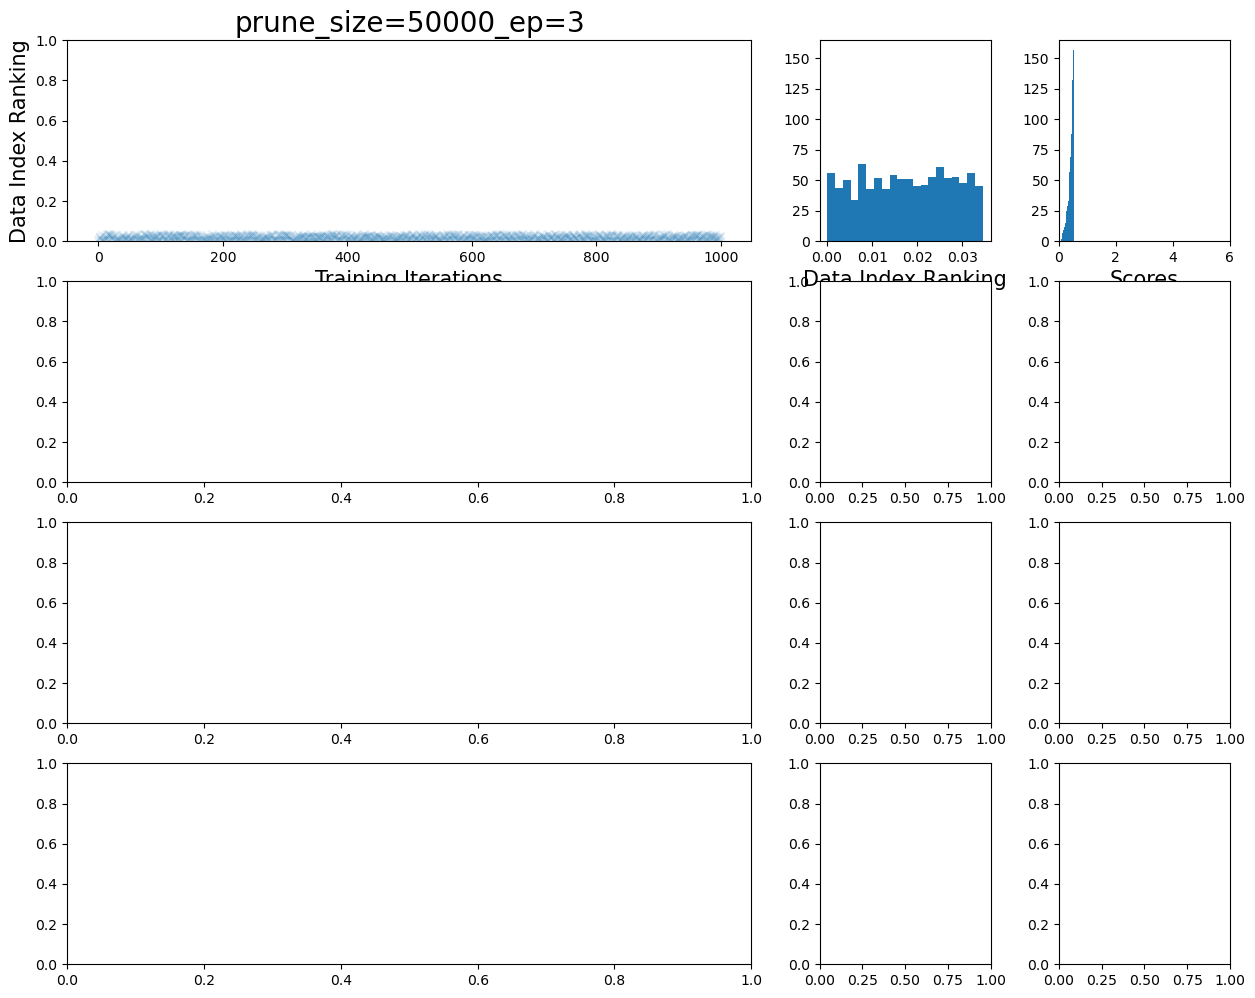

In [17]:
import re
import numpy as np
from note_curriculum import get_curriculum_scores, generate_curriculum, plt_curriculum
import glob
import matplotlib.pyplot as plt

model_name = 'mistral-7b'; dataset = 'ultrachat'; M =  50_000
# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000


paths = glob.glob('curriculum/*/*/*/scores.pkl')
paths = [x for x in paths if 'llama' in x and 'tulu_v1_mix' in x and 'log_prob_neg' in x]
path = paths[0]

verbose = True
print(path)
pacing_fn = f'prune_size={M}_ep=3'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.1'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.2'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.3'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.2_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'

pacing_fn_list = [
    f'prune_size={M}_ep=3',
    f'singlestep_size={M}_startingfrac=0.05',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.2',
#     f'singlestep_size={M}_startingfrac=0.3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=3',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.25'
]



nrows = len(pacing_fn_list)
fig, axs = plt.subplots(nrows, 3, figsize=(15,3*nrows), sharey=False, gridspec_kw={'width_ratios': [2,.5,.5]})

for i, pacing_fn in enumerate(pacing_fn_list):

    plt_kwargs = generate_curriculum(path, pacing_fn, verbose=True, save_output=False)
    output = plt_kwargs.pop('output')
    plt_kwargs.update({'fig': fig, 'axs': axs[i]})
    plt_curriculum(**plt_kwargs)

fig.tight_layout()



save_plt = 0
if save_plt:
    model_name, dataset, scoring_fn = output['model_name'], output['dataset'], output['scoring_fn']
    save_path = os.path.join(
        assets_dir, f'note_curriculum_{model_name}:{dataset}:{scoring_fn}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)



### main code

In [2]:
import os
import sys
import numpy as np
import time
import re
import random
import json
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers
import pandas as pd

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    save_prune_results,
)
from note_pruning_analysis import get_lm_output
from note_pruning_dpp import torch_vmf_kernel, torch_rbf_kernel
from functools import partial

from transformers import AutoTokenizer

from rosemary import parse_kv_from_string, create_string_from_kv
from note_pruning_analysis import lm_output_dir, get_dataset_token_lengths, get_full_model_name, md_to_model_name

import note_pruning_dpp
import note_pruning_clustering

In [3]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
dataset = 'dolly'
# dataset = 'flan2022_1m'
# dataset = 'lima'
# dataset = 'ultrachat200k'
# dataset = 'tulu_v1_mix'
# dataset = 'wizardlm'
# dataset = 'ultrachat15'
# dataset = 'starcoder_commentinstr_cleaned'

sort_by = 'random_s=0'

# used for generating model output.
model_name = 'llama-7b'
# model_name = 'llama-7b_ft=hmv1'
# model_name = 'llama-7b+lora:r=256:a=256'
# model_name = 'llama-7b+lima+lora:r=256:a=256'
# model_name = 'mistral-7b+lora:r=256:a=256'
# model_name = 'all-mpnet-base-v2'
# model_name = 'bge-large-en-v1.5'
# model_name = 'codellama-7b+lora:r=256:a=256'


# save_dir = f"data_inds/"
# from note_pruning import get_final_model_name
# model_name_ = get_final_model_name(model_name, sort_by)
# save_dir = os.path.join(save_dir, model_name_, dataset)
# os.makedirs(save_dir, exist_ok=True) 

# print(dataset, model_name, sort_by)
# print(save_dir)

In [4]:
from note_pruning_dpp import get_dppmap_run_info
import re
import numpy as np
from rosemary import parse_kv_from_string, create_string_from_kv
from note_curriculum import get_curriculum_scores
from note_pruning_analysis import curriculum_dir
from note_pruning import get_dppmap_autotune_gamma_search_result
import note_pruning_dpp
import json
from note_pruning import parse_sort_by_and_compute_dppmap

kmd = 'llama7b'
kmd = 'llama7br512p4096'


dataset = 'stanford_alpaca'
gamma = 2e-4
# sort_by = f'dppmap_k=vmf_gamma=auto1000_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@0'
# sort_by = f'dppmap_k=vmf_gamma={gamma}_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@0'
# sort_by = f'dppmap_k=vmf_gamma={gamma}_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@1'
# sort_by = f'dppmap_k=vmf_gamma={gamma}_kmd={kmd}_kemb=grad+rp+loraB'
# sort_by = f'dppmap_k=lin_gamma=1_kmd={kmd}_kemb=grad+rp+loraB'
# sort_by = f'dppmap_k=lin_gamma=10_kmd={kmd}_kemb=grad+rp+loraB'

# dataset = 'sharegptv2'
# sort_by = f'dppmap_k=vmf_gamma=auto1000_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@1'


# parse_sort_by_and_compute_dppmap(sort_by, dataset)

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy

from matplotlib import font_manager
font_path = '/dccstor/data-pruning/miniconda3/pkgs/mscorefonts-0.0.1-3/fonts/times.ttf'  # Your font path goes here
font_path = '/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/pkgs/mscorefonts-0.0.1-3/fonts/times.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [15]:
##### measure stochasticity from sampling refernece dataset

from functools import partial
import scipy


def subtract_to_smaller_size(a,b):
    l = min(len(a), len(b))
    return a[:l] - b[:l]


def compute_LDDs(L_greedy_objs, R_greedy_objs):
    logdetL = np.cumsum(L_greedy_objs)
    logdetR = np.cumsum(R_greedy_objs)
    l = min(len(logdetL), len(logdetR))
    LDDs = (logdetR[:l] - logdetL[:l]) / (np.arange(l)+1)
    return LDDs

dataset = 'stanford_alpaca50k'
L_greedy_objs = get_dppmap_marginal_gains(f'dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB', dataset)

L = []
for seed in [0,1,2,3,4]:
    R_greedy_objs = get_dppmap_marginal_gains(f'dppmap_k=vmf_gamma=1_kmd=randspherep4096s{seed}_kemb=grad+rp+loraB', 'flan_v2')
    ldds = compute_LDDs(L_greedy_objs, R_greedy_objs)
    L.append(ldds[50_000-1])

np.mean(L), np.std(L)

NameError: name 'get_dppmap_marginal_gains' is not defined

In [6]:

def get_dppmap_marginal_gains(sort_by, dataset):
    import pickle
    from note_pruning_analysis import scripts_dir
    from note_pruning import get_dppmap_autotune_gamma_search_result
    if 'gamma=auto' in sort_by:
        try:
            d = get_dppmap_autotune_gamma_search_result(sort_by, dataset)
        except:
            return None
        sort_by = re.sub(r'auto\d+', str(d['gamma']), sort_by)
    save_path = os.path.join(scripts_dir, 'dpp', dataset, sort_by, 'data.pkl')
    if not os.path.isfile(save_path):
        print(f'get_dppmap_marginal_gains failed: cannot find {save_path}')
        return None
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    di2s = np.array(data['marginal_gains'])
    marginal_gains = np.log(di2s)# + np.log(20) #+ np.log(1e10)
    return marginal_gains



def compute_logdetL_diff(marginal_gains_dataset1, marginal_gains_dataset2):
    """ Computes logdetL_d1 - logdetL_d2. 
        return vector with length as min of the two input vectors. """
    logdetL_dataset1 = np.cumsum(marginal_gains_dataset1)
    logdetL_dataset2 = np.cumsum(marginal_gains_dataset2)
    max_len = min(len(logdetL_dataset1), len(logdetL_dataset2))
    logdetL_dataset1 = logdetL_dataset1[:max_len]
    logdetL_dataset2 = logdetL_dataset2[:max_len]
    logdetL_diff = logdetL_dataset1 - logdetL_dataset2
    return logdetL_diff

    
## alpaca variants
dataset_list = [
    'stanford_alpaca',
    'gpt4_alpaca',
    'self_instruct',
    'wizardlm_alpaca',
]

## flan variants
dataset_list = [
    'flan_v2',
    'open_orca_slim',
]

## human annotated
dataset_list = [
    'lima',
    'flan_v2',
    'dolly',
    'oasst1',
]
## distilled diverse
dataset_list = [
    'sharegptv2',
    'wizardlmv2',
    'ultrachat200kv2',
]
# dataset_list = [
#     'stanford_alpaca',
# ]
    
dataset_list = [
    'lima', 
    'dolly',
    'flan_v2',
    'oasst1',
    'sharegptv2',
    'stanford_alpaca',
    'ultrachat200kv2',
    'wizardlmv2',
    # newly added
    'gpt4_alpaca',
    'self_instruct',
    'unnatural_instructions',
    'wizardlm_alpaca',
    # pref data
#     'ultrafeedback',
]

dataset_list_name = 'all'
dataset_list_name = 'chat'

if dataset_list_name == 'chat':
    dataset_list = [
    #     'lima',
        'dolly',
        'flan_v250k',
        'stanford_alpaca50k',
        'oasst2',
        'wizardlm50k',
        'sharegpt50k',
        'ultrachat50k',
        # extra
        'gpt4_alpaca50k',
        'self_instruct50k',
    ]
elif dataset_list_name == 'all':
    dataset_list = [
        'open_orca_slim',
        'dolly',
        'flan_v250k',
        'stanford_alpaca50k',
        'oasst2',
        'wizardlm50k',
        'sharegpt50k',
        'ultrachat50k',
        'gpt4_alpaca50k',
        'self_instruct50k',
        'openai_sum',
        'shp',
        'hh_rlhf',
        'ultrafeedback',
        'wizardlm_alpaca',
    ]

    
kmd = 'llama7br512p4096'
# kmd = 'llama7b'
# sort_by = f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB'
# sort_by = f'dppmap_k=vmf_gamma=auto1000_kmd={kmd}_kemb=grad+rp+loraB'
# ord_to_sort_by = {
# #     'random:s@0': sort_by+'_ord=random:s@0',
#     'greedy': sort_by,
# }
ord_to_sort_by = {
# #     ## vmf+grad
#     'greedy': f'dppmap_k=vmf_gamma=3_kmd={kmd}_kemb=grad+rp+loraB',
#     'greedy': f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB',
#     'random:s@0': f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@0',
#     'randsphere': f'dppmap_k=vmf_gamma=1_kmd=randspherep4096_kemb=grad+rp+loraB',
    ## vmf+grad subset N first 
#     'greedy': f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB+N50000',
#     'random:s@0': f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB+N50000_ord=random:s@0',
#     ## rbf+text subset N first 
#     'greedy': f'dppmap_k=rbf_gamma=1e-3_kmd={kmd}_kemb=text+embedding+N50000',
#     'random:s@0': f'dppmap_k=rbf_gamma=1e-3_kmd={kmd}_kemb=text+embedding+N50000_ord=random:s@0',
#     ## rbf+text subset N first 
#     'greedy': f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding+N50000',
#     'random:s@0': f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding+N50000_ord=random:s@0',
# #     ###
#     'gamma=1': f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB',
#     'gamma=auto1000': f'dppmap_k=vmf_gamma=auto1000_kmd={kmd}_kemb=grad+rp+loraB',
#     'gamma=auto10000': f'dppmap_k=vmf_gamma=auto10000_kmd={kmd}_kemb=grad+rp+loraB',
# ##     rbf+text
#     'greedy': f'dppmap_k=rbf_gamma=1e-3_kmd={kmd}_kemb=text+embedding',
#     'random:s@0': f'dppmap_k=rbf_gamma=1e-3_kmd={kmd}_kemb=text+embedding_ord=random:s@0',
    ##
    ## {vmf,rbf}  x {text,grad}
    ##
#     'greedy': f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding', # mpnet text
#     'greedy': f'dppmap_k=rbf_gamma=1e-3_kmd={kmd}_kemb=text+embedding', # text
    'greedy': f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB', # grad
#     'greedy': f'dppmap_k=vmf_gamma=10_kmd={kmd}_kemb=text+embedding', # text
#     'greedy': f'dppmap_k=rbf_gamma=1e-2_kmd={md}_kemb=grad+rp+loraB', # grad
}



embedding_type = 'LM Embedding'
# embedding_type = 'mpnet Embedding'
# embedding_type = 'LM Weight Gradient'


if embedding_type == 'LM Weight Gradient':
    ord_to_sort_by = {'greedy': f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB'}
elif embedding_type == 'LM Embedding':
    ord_to_sort_by = {'greedy': f'dppmap_k=vmf_gamma=10_kmd={kmd}_kemb=text+embedding'}
elif embedding_type == 'mpnet Embedding':
    ord_to_sort_by = {'greedy': f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding'}
else:
    raise ValueError()


mgs = {
    (dataset, k): get_dppmap_marginal_gains(v, dataset) for k, v in ord_to_sort_by.items()
    for dataset in dataset_list
}
## some hack 
if 'open_orca_slim' in dataset_list:
    dataset = 'open_orca_slim'
    mgs[(dataset, 'greedy')] = get_dppmap_marginal_gains(f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB+N50000', dataset)
if 'wizardlm_alpaca' in dataset_list:
    dataset = 'wizardlm_alpaca'
    mgs[(dataset, 'greedy')] = get_dppmap_marginal_gains(f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB+N50000', dataset)
    

if embedding_type == 'LM Weight Gradient':
    randsphere_sortby = f'dppmap_k=vmf_gamma=1_kmd=randspherep4096_kemb=grad+rp+loraB'
elif embedding_type == 'LM Embedding':
    randsphere_sortby = f'dppmap_k=vmf_gamma=10_kmd=randspherep4096_kemb=grad+rp+loraB'
elif embedding_type == 'mpnet Embedding':
    randsphere_sortby = f'dppmap_k=vmf_gamma=1_kmd=randspherep768_kemb=grad+rp+loraB'
else:
    raise ValueError()

mgs.update({
    ('flan_v2', k): get_dppmap_marginal_gains(v, 'flan_v2') for k, v in {
        'randsphere': randsphere_sortby,
    }.items()
})


print('Missing: ', {k for k,v in mgs.items() if v is None})
mgs = {k: v for k, v in mgs.items() if v is not None}
list(mgs.keys())

Missing:  set()


[('dolly', 'greedy'),
 ('flan_v250k', 'greedy'),
 ('stanford_alpaca50k', 'greedy'),
 ('oasst2', 'greedy'),
 ('wizardlm50k', 'greedy'),
 ('sharegpt50k', 'greedy'),
 ('ultrachat50k', 'greedy'),
 ('gpt4_alpaca50k', 'greedy'),
 ('self_instruct50k', 'greedy'),
 ('flan_v2', 'randsphere')]

# correlate 20% selection performance with LDD

In [12]:
d = {('Datasets', 'Methods'): 
     {0: 'Random', 1: 'DPP (Llama $\\nabla_{\\theta}\\ell$)', 
      2: 'DPP (Llama $\\nabla_{\\theta}\\ell$) Not Norm.', 
      3: 'DPP (Llama Emb Not Norm.)', 4: 'DPP (Llama Emb)', 
      5: 'DPP (MpNet Emb)', 6: 'Dedup(MpNet Emb)', 7: '$\\norm{\\nabla_{\\theta} \\ell}_2$ ($\\downarrow$)', 
      8: 'Alpagasus Rating ($\\uparrow$)', 9: 'EL2N ($\\downarrow$)', 10: 'IFD ($\\uparrow$)', 
      11: 'Perplexity ($\\downarrow$)', 12: '\\#Input Tokens ($\\uparrow$)', 
      13: '\\#Output Tokens ($\\uparrow$)', 14: '\\#Total Tokens ($\\uparrow$)', 
      15: 'DPP (Llama $\\nabla_{\\theta}\\ell$ + \\#Output Toks $\\theta=0.1$)', 
      16: 'DPP (Llama $\\nabla_{\\theta}\\ell$ + \\#Output Toks $\\theta=0.3$)', 
      17: 'DPP (Llama $\\nabla_{\\theta}\\ell$ + \\#Output Toks $\\theta=0.6$)', 
      18: 'DPP (Llama $\\nabla_{\\theta}\\ell$ + \\#Output Toks)'}, 
     ('Alpaca', '\\makecell{Benchmark \\\\ Avg}'): 
     {0: 21.586655617298028, 1: 21.70769492361744, 2: 22.726482591700417, 3: 22.0979453675226, 
      4: 22.515489588242797, 5: 22.853927816002674, 6: 22.845217769457744, 7: 22.673602078282105, 
      8: 21.58587457354841, 9: 22.82543649585082, 10: 21.492337930416962, 11: 22.688455906562773, 
      12: 25.132897226301083, 13: 23.367317078941642, 14: 20.389618799076796, 15: 23.075241860652095, 
      16: 23.6697567241169, 17: 23.585770438162967, 18: 23.470334872332288}, 
     ('Alpaca', '\\makecell{AlpacaEval \\\\ LC-\\% Win}'): 
     {0: 27.119138113316094, 1: 28.527044681317253, 2: 15.364794573288687, 3: 27.454508661958503, 
      4: 26.57200403269087, 5: 25.161296537030143, 6: 24.24367346935219, 7: 30.874688529370143, 
      8: 27.21130586572541, 9: 23.631640343471936, 10: 27.038329254698645, 11: 28.54330332388978, 
      12: 22.836626033115866, 13: 30.86699543795891, 14: 29.66932063632551, 15: 32.389063290175, 16: 30.97004822873226, 17: 29.66531259576764, 
      18: 29.205498234582763}, ('Alpaca', '\\makecell{ \\\\ Len}'): 
     {0: 90.05183312262959, 1: 103.78333333333333, 2: 33.88944723618091, 3: 92.58015267175573, 4: 91.74775928297055, 5: 87.8733850129199, 6: 84.87435897435897, 
      7: 136.14030612244898, 8: 95.00904392764858, 9: 98.68147208121827, 10: 113.19687092568448, 11: 105.8510101010101, 12: 87.9037711313394, 13: 151.74615384615385, 
      14: 149.1853281853282, 15: 122.08111533586819, 16: 130.89144316730523, 17: 139.18346253229973, 18: 150.23346303501947}, ('Alpaca', '\\makecell{AlpacaEval \\\\ \\% Win}'): {0: 18.26086956521739, 1: 26.27329192546584, 2: 7.639751552795031, 3: 21.67701863354037, 4: 20.93167701863354, 5: 19.440993788819878, 6: 18.509316770186334, 7: 36.95652173913043, 8: 21.242236024844722, 9: 21.180124223602487, 10: 29.316770186335404, 11: 25.341614906832298, 12: 18.757763975155278, 13: 39.37888198757764, 14: 37.391304347826086, 15: 35.3416149068323, 16: 39.006211180124225, 17: 40.12422360248447, 18: 40.43478260869565}, ('UltraChat', '\\makecell{Benchmark \\\\ Avg}'): {0: 22.62959298527265, 1: 23.301394416284534, 2: 22.679686641480327, 3: 23.24370437693765, 4: 23.30406426737403, 5: 23.250675018027263, 6: 22.99422764911573, 7: 23.266910258392393, 8: np.nan, 9: 22.700041750787054, 10: 22.997530195603925, 11: 22.828419292719143, 12: 22.861764183642265, 13: 22.670826821605473, 14: 22.654575683604314, 15: np.nan, 16: np.nan, 17: np.nan, 18: 22.635577741318045}, ('UltraChat', '\\makecell{AlpacaEval \\\\ LC-\\% Win}'): {0: 36.41580753054116, 1: 36.904490359366754, 2: 36.42554810533453, 3: 37.719599174650234, 4: 35.25878486393304, 5: 35.27188660137868, 6: 39.11837747944911, 7: 37.77209632213875, 8: np.nan, 9: 36.66017635333701, 10: 38.29593869408444, 11: 36.72625066760657, 12: 35.31066862393464, 13: 37.557138989133, 14: 37.876224153477104, 15: np.nan, 16: np.nan, 17: np.nan, 18: 38.637536163267555}, ('UltraChat', '\\makecell{ \\\\ Len}'): {0: 213.41603053435114, 1: 217.0306905370844, 2: 197.00509554140126, 3: 214.6854942233633, 4: 204.24675324675326, 5: 210.8869123252859, 6: 219.02709677419355, 7: 248.56482670089858, 8: np.nan, 9: 220.4407643312102, 10: 271.43790012804095, 11: 230.80357142857142, 12: 216.79419525065964, 13: 261.9548969072165, 14: 250.66753246753248, 15: np.nan, 16: np.nan, 17: np.nan, 18: 272.9935897435897}, ('UltraChat', '\\makecell{AlpacaEval \\\\ \\% Win}'): {0: 56.89440993788819, 1: 58.012422360248436, 2: 53.41614906832298, 3: 55.21739130434782, 4: 52.04968944099379, 5: 57.51552795031055, 6: 57.63975155279504, 7: 62.85714285714287, 8: np.nan, 9: 55.46583850931677, 10: 62.2360248447205, 11: 59.62732919254658, 12: 50.68322981366459, 13: 63.16770186335404, 14: 60.931677018633536, 15: np.nan, 16: np.nan, 17: np.nan, 18: 63.788819875776404}}

df_tab1 = pd.DataFrame(d)

md = 'llama7br512p4096'

df_tab1[('Datasets', 'Methods')] = [
    'random_s=0', 
    f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB',
    f'dppmap_k=rbf_gamma=1e-2_kmd={md}_kemb=grad+rp+loraB',
    f'dppmap_k=rbf_gamma=1e-3_kmd={md}_kemb=text+embedding',
    f'dppmap_k=vmf_gamma=10_kmd={md}_kemb=text+embedding',
    f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding',
    f'dedup_dist=cd_md=mpnet_emb=text+embedding',
    'grad_loraB_l2n',
    'alpagasus_rating_neg',
    'el2n_agg=mean',
    'ifd_neg',
    'log_prob_neg',
    'numtoks_input_neg', 'numtoks_output_neg', 'numtoks_total_neg',
] + [
    f'dppmap_k=vmf_gamma=1_theta={theta}_kmd={md}_kemb=grad+rp+loraB_q=numtoks+output_qmd={md}' for theta in [0.1,0.3,0.6,0.9] # [0.1, .3, .6, .9]
]

df_tab1 = df_tab1[df_tab1[('Datasets', 'Methods')].apply(lambda x: '0.3' not in x and '0.6' not in x and '0.9' not in x and '1e-2' not in x)]
df_tab1


Datasets  \
                                              Methods   
0                                          random_s=0   
1   dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb...   
3   dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_k...   
4   dppmap_k=vmf_gamma=10_kmd=llama7br512p4096_kem...   
5   dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embed...   
6           dedup_dist=cd_md=mpnet_emb=text+embedding   
7                                      grad_loraB_l2n   
8                                alpagasus_rating_neg   
9                                       el2n_agg=mean   
10                                            ifd_neg   
11                                       log_prob_neg   
12                                  numtoks_input_neg   
13                                 numtoks_output_neg   
14                                  numtoks_total_neg   
15  dppmap_k=vmf_gamma=1_theta=0.1_kmd=llama7br512...   

                        Alpaca                                     \
   \makecell{Benchmark \\ Avg} \makecell{AlpacaEval \\ LC-\% Win}   
0                    21.586656                          27.119138   
1                    21.707695                          28.527045   
3                    22.097945                          27.454509   
4                    22.515490                          26.572004   
5                    22.853928                          25.161297   
6                    22.845218                          24.243673   
7                    22.673602                          30.874689   
8                    21.585875                          27.211306   
9                    22.825436                          23.631640   
10                   21.492338                          27.038329   
11                   22.688456                          28.543303   
12                   25.132897                          22.836626   
13                   23.367317                          30.866995   
14                   20.389619                          29.669321   
15                   23.075242                          32.389063   

                                                       \
   \makecell{ \\ Len} \makecell{AlpacaEval \\ \% Win}   
0           90.051833                       18.260870   
1          103.783333                       26.273292   
3           92.580153                       21.677019   
4           91.747759                       20.931677   
5           87.873385                       19.440994   
6           84.874359                       18.509317   
7          136.140306                       36.956522   
8           95.009044                       21.242236   
9           98.681472                       21.180124   
10         113.196871                       29.316770   
11         105.851010                       25.341615   
12          87.903771                       18.757764   
13         151.746154                       39.378882   
14         149.185328                       37.391304   
15         122.081115                       35.341615   

                     UltraChat                                     \
   \makecell{Benchmark \\ Avg} \makecell{AlpacaEval \\ LC-\% Win}   
0                    22.629593                          36.415808   
1                    23.301394                          36.904490   
3                    23.243704                          37.719599   
4                    23.304064                          35.258785   
5                    23.250675                          35.271887   
6                    22.994228                          39.118377   
7                    23.266910                          37.772096   
8                          NaN                                NaN   
9                    22.700042                          36.660176   
10                   22.997530                          38.295939   
11                   22.828419                          36.726251   
12                   22.861764    

In [13]:
import matplotlib.pyplot as plt
from functools import partial
import scipy


def subtract_to_smaller_size(a,b):
    l = min(len(a), len(b))
    return a[:l] - b[:l]


def compute_LDDs(L_greedy_objs, R_greedy_objs):
    logdetL = np.cumsum(L_greedy_objs)
    logdetR = np.cumsum(R_greedy_objs)
    l = min(len(logdetL), len(logdetR))
    LDDs = (logdetR[:l] - logdetL[:l]) / (np.arange(l)+1)
    return LDDs

def compute_ldd_from_ordering(ordering, dataset, N, ldd_kernel):
    sort_by = f"{ldd_kernel}_ord={re.sub('_', ':', re.sub('=', '@', ordering))}"
    L_greedy_objs = get_dppmap_marginal_gains(sort_by, dataset)
    if L_greedy_objs is None:
        return np.nan
    else:
        if ldd_kernel == f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB':
            randsphere_sortby = f'dppmap_k=vmf_gamma=1_kmd=randspherep4096_kemb=grad+rp+loraB'
        elif ldd_kernel == f'dppmap_k=vmf_gamma=10_kmd={md}_kemb=text+embedding':
            randsphere_sortby = f'dppmap_k=vmf_gamma=10_kmd=randspherep4096_kemb=grad+rp+loraB'
        elif ldd_kernel == f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding':
            randsphere_sortby = f'dppmap_k=vmf_gamma=1_kmd=randspherep768_kemb=grad+rp+loraB'
        else:
            raise ValueError()
        R_greedy_objs = get_dppmap_marginal_gains(randsphere_sortby, 'flan_v2')
        ldds = compute_LDDs(L_greedy_objs, R_greedy_objs)
        if N<len(ldds):
            return ldds[N]
        else:
            print(ordering, dataset, N, ldd_kernel, f'\nN={N} >= len(ldds)={len(ldds)}')
            return ldds[-1]
    
    
N = 10_000
    
for ldd_kernel in [
    f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB',
##     f'dppmap_k=rbf_gamma=1e-3_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding',
#     f'dppmap_k=vmf_gamma=10_kmd={md}_kemb=text+embedding',
]:
    ldd_name = f'LDD_{ldd_kernel}'
    df_tab1[('Alpaca', ldd_name)] = df_tab1[('Datasets', 'Methods')].apply(partial(compute_ldd_from_ordering, dataset='stanford_alpaca50k', N=N, ldd_kernel=ldd_kernel))
    df_tab1[('UltraChat', ldd_name)] = df_tab1[('Datasets', 'Methods')].apply(partial(compute_ldd_from_ordering, dataset='ultrachat50k', N=N, ldd_kernel=ldd_kernel))
df_tab1

get_dppmap_marginal_gains failed: cannot find /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/dpp/stanford_alpaca50k/dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB_ord=alpagasus:rating:neg/data.pkl
get_dppmap_marginal_gains failed: cannot find /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/dpp/ultrachat50k/dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB_ord=alpagasus:rating:neg/data.pkl
get_dppmap_marginal_gains failed: cannot find /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/dpp/ultrachat50k/dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB_ord=dppmap:k@vmf:gamma@1:theta@0.1:kmd@llama7br512p4096:kemb@grad+rp+loraB:q@numtoks+output:qmd@llama7br512p4096/data.pkl


Datasets  \
                                              Methods   
0                                          random_s=0   
1   dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb...   
3   dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_k...   
4   dppmap_k=vmf_gamma=10_kmd=llama7br512p4096_kem...   
5   dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embed...   
6           dedup_dist=cd_md=mpnet_emb=text+embedding   
7                                      grad_loraB_l2n   
8                                alpagasus_rating_neg   
9                                       el2n_agg=mean   
10                                            ifd_neg   
11                                       log_prob_neg   
12                                  numtoks_input_neg   
13                                 numtoks_output_neg   
14                                  numtoks_total_neg   
15  dppmap_k=vmf_gamma=1_theta=0.1_kmd=llama7br512...   

                        Alpaca                                     \
   \makecell{Benchmark \\ Avg} \makecell{AlpacaEval \\ LC-\% Win}   
0                    21.586656                          27.119138   
1                    21.707695                          28.527045   
3                    22.097945                          27.454509   
4                    22.515490                          26.572004   
5                    22.853928                          25.161297   
6                    22.845218                          24.243673   
7                    22.673602                          30.874689   
8                    21.585875                          27.211306   
9                    22.825436                          23.631640   
10                   21.492338                          27.038329   
11                   22.688456                          28.543303   
12                   25.132897                          22.836626   
13                   23.367317                          30.866995   
14                   20.389619                          29.669321   
15                   23.075242                          32.389063   

                                                       \
   \makecell{ \\ Len} \makecell{AlpacaEval \\ \% Win}   
0           90.051833                       18.260870   
1          103.783333                       26.273292   
3           92.580153                       21.677019   
4           91.747759                       20.931677   
5           87.873385                       19.440994   
6           84.874359                       18.509317   
7          136.140306                       36.956522   
8           95.009044                       21.242236   
9           98.681472                       21.180124   
10         113.196871                       29.316770   
11         105.851010                       25.341615   
12          87.903771                       18.757764   
13         151.746154                       39.378882   
14         149.185328                       37.391304   
15         122.081115                       35.341615   

                     UltraChat                                     \
   \makecell{Benchmark \\ Avg} \makecell{AlpacaEval \\ LC-\% Win}   
0                    22.629593                          36.415808   
1                    23.301394                          36.904490   
3                    23.243704                          37.719599   
4                    23.304064                          35.258785   
5                    23.250675                          35.271887   
6                    22.994228                          39.118377   
7                    23.266910                          37.772096   
8                          NaN                                NaN   
9                    22.700042                          36.660176   
10                   22.997530                          38.295939   
11                   22.828419                          36.726251   
12                   22.861764    

Alpaca


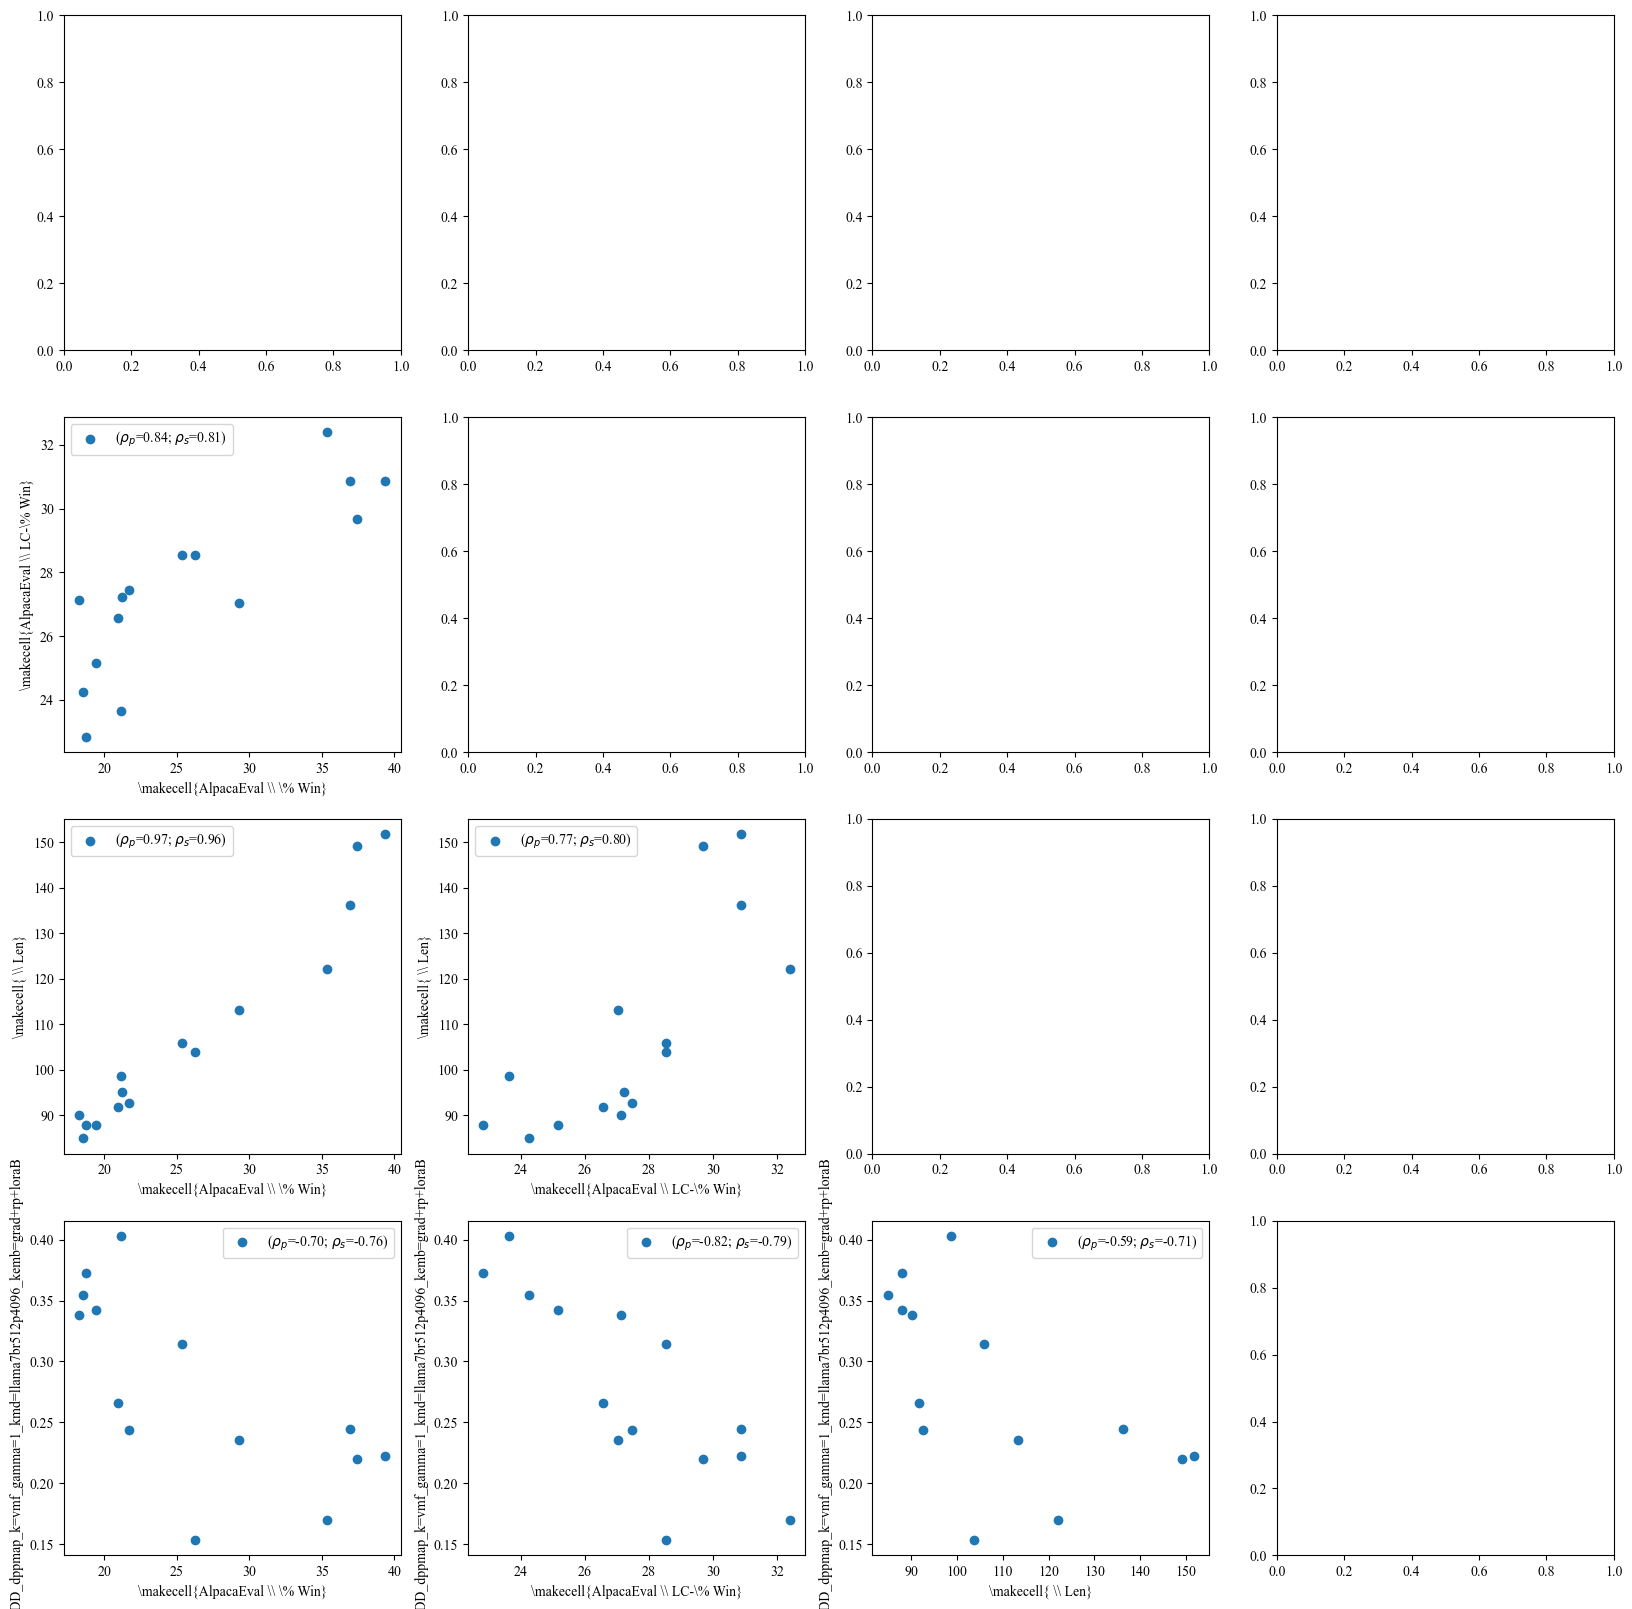

In [14]:


datasets = ['Alpaca', 'UltraChat']
# ldd_name = 'LDD_' + f'dppmap_k=vmf_gamma=10_kmd={md}_kemb=text+embedding'
ldd_name = 'LDD_' + f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB'
# ldd_name = 'LDD_' + f'dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embedding'

perf_names = [r'\makecell{Benchmark \\ Avg}', r'\makecell{AlpacaEval \\ \% Win}', r'\makecell{ \\ Len}', ldd_name]
perf_names = [r'\makecell{AlpacaEval \\ \% Win}', r'\makecell{AlpacaEval \\ LC-\% Win}', r'\makecell{ \\ Len}', ldd_name]

dataset = 'Alpaca'
# dataset = 'UltraChat'

ncols = len(perf_names)
nrows = ncols
w = 5
fig, axs = plt.subplots(nrows,ncols,figsize=(w*ncols,w*nrows))

print(dataset)
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i,j]
        if j >= i:
            continue
        perf_name_y = perf_names[i]
        perf_name_x = perf_names[j]
        
        dfc = df_tab1.dropna(subset=[(dataset, perf_name_x), (dataset, perf_name_y)])

        xs = dfc[(dataset, perf_name_x)].to_numpy()
        ys = dfc[(dataset, perf_name_y)].to_numpy()

        ρ = scipy.stats.pearsonr(xs, ys).statistic
        ρs = scipy.stats.spearmanr(xs, ys).statistic
        ax.scatter(xs, ys, label=r'($\rho_{p}$'+f'={ρ:.2f}; '+r'$\rho_{s}$'+f'={ρs:.2f})')
        ax.legend()
#         ax.set_title()
        ax.set_xlabel(perf_name_x)
        ax.set_ylabel(perf_name_y)



In [15]:
df_tab1

Datasets  \
                                              Methods   
0                                          random_s=0   
1   dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb...   
3   dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_k...   
4   dppmap_k=vmf_gamma=10_kmd=llama7br512p4096_kem...   
5   dppmap_k=vmf_gamma=1_kmd=mpnet_kemb=text+embed...   
6           dedup_dist=cd_md=mpnet_emb=text+embedding   
7                                      grad_loraB_l2n   
8                                alpagasus_rating_neg   
9                                       el2n_agg=mean   
10                                            ifd_neg   
11                                       log_prob_neg   
12                                  numtoks_input_neg   
13                                 numtoks_output_neg   
14                                  numtoks_total_neg   
15  dppmap_k=vmf_gamma=1_theta=0.1_kmd=llama7br512...   

                        Alpaca                                     \
   \makecell{Benchmark \\ Avg} \makecell{AlpacaEval \\ LC-\% Win}   
0                    21.586656                          27.119138   
1                    21.707695                          28.527045   
3                    22.097945                          27.454509   
4                    22.515490                          26.572004   
5                    22.853928                          25.161297   
6                    22.845218                          24.243673   
7                    22.673602                          30.874689   
8                    21.585875                          27.211306   
9                    22.825436                          23.631640   
10                   21.492338                          27.038329   
11                   22.688456                          28.543303   
12                   25.132897                          22.836626   
13                   23.367317                          30.866995   
14                   20.389619                          29.669321   
15                   23.075242                          32.389063   

                                                       \
   \makecell{ \\ Len} \makecell{AlpacaEval \\ \% Win}   
0           90.051833                       18.260870   
1          103.783333                       26.273292   
3           92.580153                       21.677019   
4           91.747759                       20.931677   
5           87.873385                       19.440994   
6           84.874359                       18.509317   
7          136.140306                       36.956522   
8           95.009044                       21.242236   
9           98.681472                       21.180124   
10         113.196871                       29.316770   
11         105.851010                       25.341615   
12          87.903771                       18.757764   
13         151.746154                       39.378882   
14         149.185328                       37.391304   
15         122.081115                       35.341615   

                     UltraChat                                     \
   \makecell{Benchmark \\ Avg} \makecell{AlpacaEval \\ LC-\% Win}   
0                    22.629593                          36.415808   
1                    23.301394                          36.904490   
3                    23.243704                          37.719599   
4                    23.304064                          35.258785   
5                    23.250675                          35.271887   
6                    22.994228                          39.118377   
7                    23.266910                          37.772096   
8                          NaN                                NaN   
9                    22.700042                          36.660176   
10                   22.997530                          38.295939   
11                   22.828419                          36.726251   
12                   22.861764    

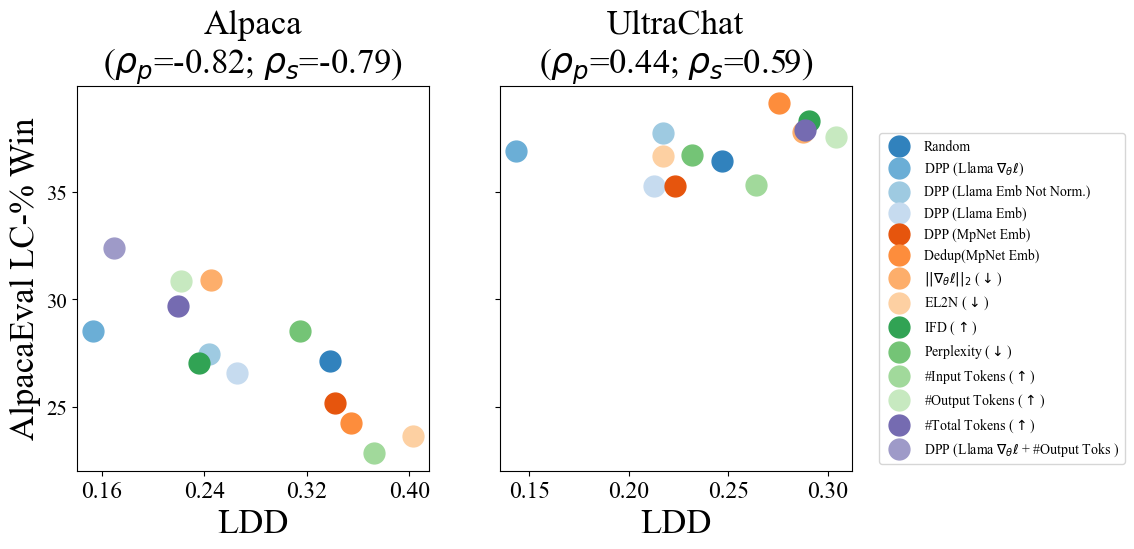

In [16]:
from llm.evaluate import sort_by_name_mapper

from rosemary import parse_kv_from_string
from matplotlib.ticker import MaxNLocator

import matplotlib.pyplot as plt
rcparams = {
    'lines.markersize': 15, # dot in curve size.
    'axes.titlesize': 25,   # ax title
    'axes.labelsize': 25,   # labels (x-axis and y-axis)
    'xtick.labelsize': 17,  # xtick size
    'ytick.labelsize': 15,  # ytick size
    'figure.labelsize': 25, # 
    'legend.fontsize': 12,  #| legend font size
    'lines.linewidth': 3,
    'xtick.top': False,
    'xtick.bottom': True,
}

cmap = plt.get_cmap('tab20c')
methods = dfc[('Datasets', 'Methods')].to_list()
def color_fn(method):
    i = methods.index(method)
    return cmap(i)

with mpl.rc_context(rcparams):


    datasets = ['Alpaca', 'UltraChat']
    ncols = len(datasets)
    nrows = 1
    w = 5
    fig, axs = plt.subplots(nrows,ncols,figsize=(w*ncols,w*nrows), sharey=True)

    for i in range(nrows):
        for j in range(ncols):
            ax = axs.reshape(nrows, ncols)[i,j]
            xs_labelname = 'LDD_' + f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB'
            ys_labelname = r'\makecell{AlpacaEval \\ LC-\% Win}'

            dataset = datasets[j]
            dfc = df_tab1.dropna(subset=[(dataset, xs_labelname), (dataset, ys_labelname)])
            methods = dfc[('Datasets', 'Methods')].to_list()

            xs = dfc[(dataset, xs_labelname)].to_list()
            ys = dfc[(dataset, ys_labelname)].to_list()

            ρ = scipy.stats.pearsonr(xs, ys).statistic
            ρs = scipy.stats.spearmanr(xs, ys).statistic
            for _, (x, y, method) in enumerate(zip(xs, ys, methods)):
                color = color_fn(method)
                
                kvs = parse_kv_from_string(method)
                s = '_'.join([str(v) for k, v in kvs.items()])
                label = sort_by_name_mapper[s]
                if label == '$\\norm{\\nabla_{\\theta} \\ell}_2$ ($\\downarrow$)':
                    label = '$||\\nabla_{\\theta} \\ell ||_2$ ($\\downarrow$)'
                label = label.replace('$\\theta=0.1$', '')
                label = label.replace('\#', '#')
                ax.scatter(x, y, color=color, label=label)
            ax.set_title(f'{dataset}\n'+r'($\rho_{p}$'+f'={ρ:.2f}; '+r'$\rho_{s}$'+f'={ρs:.2f})')
            if j == 0:
                ax.set_ylabel('AlpacaEval LC-% Win')
            ax.set_xlabel('LDD')
            ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
            ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

            
handles, labels = axs[0].get_legend_handles_labels() 
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.05, 0.11), ncol=1, frameon=True)

In [88]:
labels

['Random',
 'DPP (Llama $\\nabla_{\\theta}\\ell$)',
 'DPP (Llama Emb Not Norm.)',
 'DPP (Llama Emb)',
 'DPP (MpNet Emb)',
 'Dedup(MpNet Emb)',
 '$||\\nabla_{\\theta} \\ell ||_2$ ($\\downarrow$)',
 'Alpagasus Rating ($\\uparrow$)',
 'EL2N ($\\downarrow$)',
 'IFD ($\\uparrow$)',
 'Perplexity ($\\downarrow$)',
 '#Input Tokens ($\\uparrow$)',
 '#Output Tokens ($\\uparrow$)',
 '#Total Tokens ($\\uparrow$)',
 'DPP (Llama $\\nabla_{\\theta}\\ell$ + #Output Toks $\\theta=0.1$)']

In [193]:
import matplotlib.pyplot as plt

def get_dataset_display(dataset):
    if 'dolly' in dataset: return 'Dolly'
    elif 'stanford_alpaca' in dataset: return 'Alpaca'
    elif 'ultrachat' in dataset: return 'UltraChat'
    elif 'sharegpt' in dataset: return 'ShareGPT'
    elif 'ultrafeedback' in dataset: return 'UltraFeedback'
    elif 'flan_v2' in dataset: return "FLAN"
    elif 'oasst2' in dataset: return "OASST2"
    elif 'wizardlm' in dataset: return "WizardLM"
    elif 'gpt4_alpaca' in dataset: return 'GPT4-Alpaca'
    elif 'self_instruct' in dataset: return 'Self-Instruct'
    elif 'ref' in dataset: return 'Reference'
    elif 'openai_sum' in dataset: return 'Openai-Summariation'
    elif 'hh_rlhf' in dataset: return 'HH-RLHF'
    elif 'shp' in dataset: return 'SHP'
    elif 'ultrafeedback' in dataset: return 'UltraFeedback'
    elif 'open_orca' in dataset: return 'Open-Orca'
    elif 'lima' in dataset: return 'LIMA'
    else: raise ValueError(f'{dataset} not defined display name')
        
def subtract_to_smaller_size(a,b):
    l = min(len(a), len(b))
    return a[:l] - b[:l]

# # gpt4 alpacaeval v1.0 winrate.
# perfs = {'flan_v250k': 2.111801242236025, 'self_instruct50k': 5.77639751552795, 'dolly': 13.167701863354036, 'stanford_alpaca50k': 21.304347826086957, 'oasst2': 49.93788819875776, 'wizardlm50k': 60.745341614906835, 'ultrachat50k': 63.72670807453416, 'gpt4_alpaca50k': 63.913043478260875, 'sharegpt50k': 67.51552795031056}
# gpt4-turbo Length-controlled winrate.
perfs = {'sharegpt50k': 38.03065846890563, 'wizardlm50k': 35.382812494761055, 'ultrachat50k': 40.257504805638774, 'gpt4_alpaca50k': 37.57532385492707, 'oasst2': 30.51178875149117, 'stanford_alpaca50k': 28.319525447868127, 'dolly': 15.758281735905047, 'flan_v250k': 6.376308577321406, 'self_instruct50k': 9.295872798702451}
# AcademicBench={'self_instruct50k': 20.915758757323502, 'oasst2': 22.217772301009884, 'ultrachat50k': 22.90774015084645, 'stanford_alpaca50k': 22.989997233965415, 'gpt4_alpaca50k': 23.189254803071105, 'dolly': 24.081346866510223, 'wizardlm50k': 24.222268910222496, 'sharegpt50k': 24.45554782583774, 'flan_v250k': 26.426821396438108}

perfs = {get_dataset_display(k): v for k, v in perfs.items()}


delta_threshold = -5
delta_threshold = -7
# delta_threshold = -20


delta = {}
delta.update({
    get_dataset_display('ref'): mgs[('flan_v2', 'randsphere')]
})
delta.update({
    get_dataset_display(dataset): mgs[(dataset, 'greedy')] for dataset in dataset_list if (dataset, 'greedy') in mgs
})
print(f'remove delta that is < {delta_threshold}')
delta_after = {k: v[np.where(v>=delta_threshold)[0]] for k, v in delta.items()}
print({k: f'{v.shape[0]} -> {delta_after[k].shape[0]}' for k, v in delta.items()})
delta = delta_after
logdetL = {k: np.cumsum(v) for k, v in delta.items()}

delta_diff = {k: subtract_to_smaller_size(v, delta['Reference']) for k, v in delta.items() if k!='Reference'}
logdetL_diff = {k: subtract_to_smaller_size(v, logdetL['Reference']) for k, v in logdetL.items() if k!='Reference'}

divs = {k: -v[-1]/len(v) for k, v in logdetL_diff.items()} # -1/n*(logdet(L)-logdet(R))
ordering = list(x[0] for x in sorted(divs.items(), key=lambda x: x[1], reverse=True))

delta = {k: delta[k] for k in ordering+['Reference']}
delta_diff = {k: delta_diff[k] for k in ordering}
logdetL = {k: logdetL[k] for k in ordering+['Reference']}
logdetL_diff = {k: logdetL_diff[k] for k in ordering}

print('ordering: ', ordering)

remove delta that is < -7
{'Reference': '55000 -> 55000', 'Dolly': '14955 -> 14952', 'FLAN': '50000 -> 49984', 'Alpaca': '50000 -> 50000', 'OASST2': '48342 -> 47752', 'WizardLM': '49999 -> 49991', 'ShareGPT': '49944 -> 45605', 'UltraChat': '50000 -> 50000', 'GPT4-Alpaca': '50000 -> 50000', 'Self-Instruct': '50000 -> 49987'}
ordering:  ['OASST2', 'Self-Instruct', 'UltraChat', 'FLAN', 'ShareGPT', 'WizardLM', 'GPT4-Alpaca', 'Alpaca', 'Dolly']


## a list of curation trends to compare

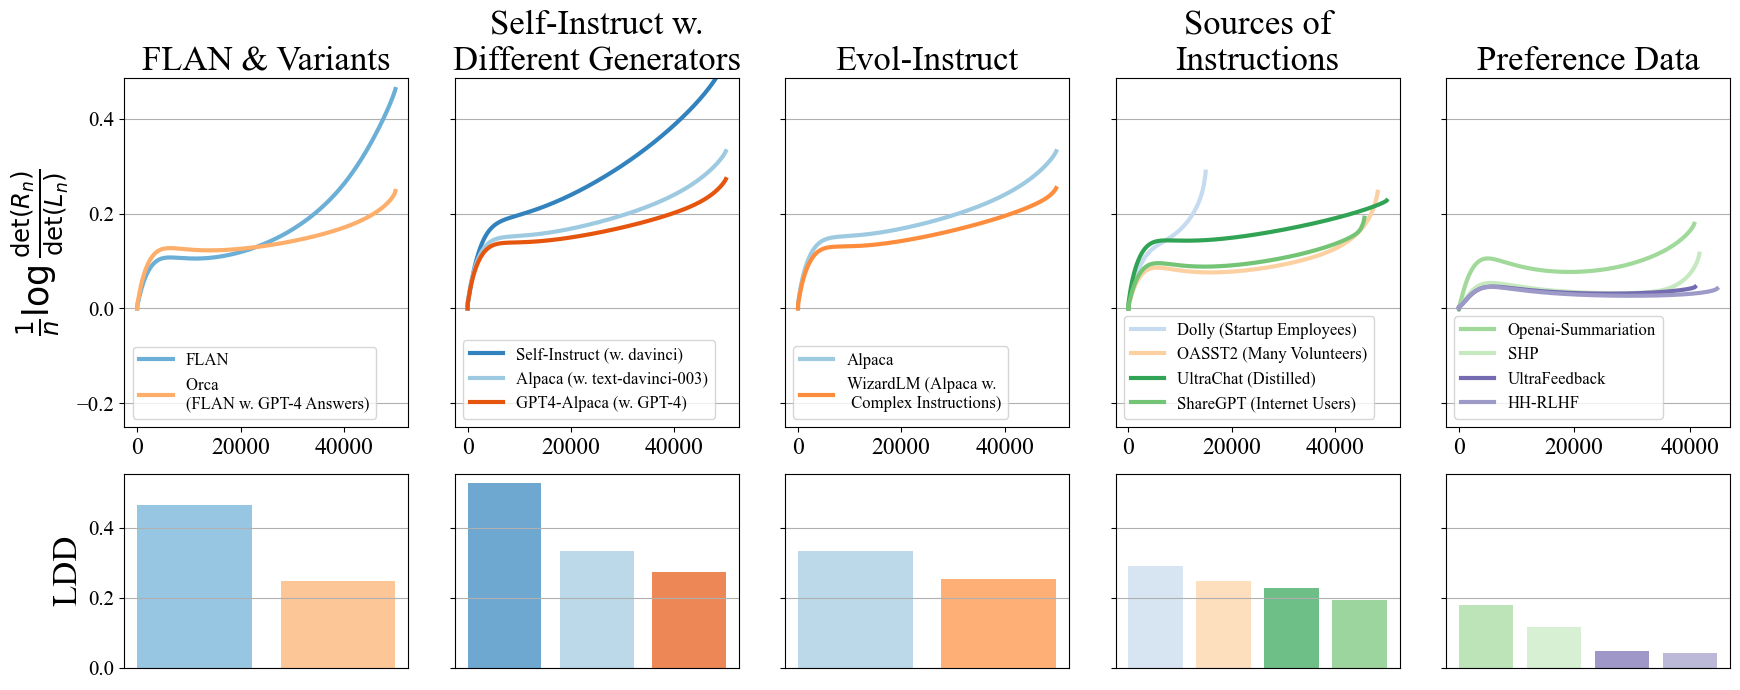

In [181]:
assert(dataset_list_name=='all')
rcparams = {
    'lines.markersize': 15, # dot in curve size.
    'axes.titlesize': 25,   # ax title
    'axes.labelsize': 25,   # labels (x-axis and y-axis)
    'xtick.labelsize': 17,  # xtick size
    'ytick.labelsize': 15,  # ytick size
    'figure.labelsize': 25, # 
    'legend.fontsize': 12,  #| legend font size
    'lines.linewidth': 3,
    'xtick.top': False,
    'xtick.bottom': True,
}

cmap = plt.get_cmap('tab20c')
def color_fn(dataset):
    i = list(delta.keys()).index(dataset)
    return cmap(i)

spacings = 10

# wizardlm_alpaca
datsets_groups = {
    'FLAN & Variants': (
        ['flan_v250k', 'open_orca_slim'],
        ['FLAN', 'Orca \n(FLAN w. GPT-4 Answers)']
    ),
    'Self-Instruct w.\nDifferent Generators': (
        ['self_instruct50k', 'stanford_alpaca50k', 'gpt4_alpaca50k'],
        [r'Self-Instruct (w. davinci)', 'Alpaca (w. text-davinci-003)', 'GPT4-Alpaca (w. GPT-4)']
    ),
    'Evol-Instruct': (
        ['stanford_alpaca50k', 'wizardlm_alpaca'],
        ['Alpaca', 'WizardLM (Alpaca w.\n Complex Instructions)']
    ),
#     'Human Annotated': ['flan_v250k', 'dolly', 'oasst2'],
#     'Distilled': ['sharegpt50k, wizardlm50k', 'ultrachat50k'],
    'Sources of\nInstructions': ( # Human Annotated\nvs. Distilled
        ['dolly', 'oasst2', 'sharegpt50k', 'ultrachat50k'],
#         ['Dolly (Human)', 'OASST2 (Human)', 'ShareGPT (Distilled)', 'UltraChat (Distilled)'],
        [r'Dolly (Startup Employees)', r'OASST2 (Many Volunteers)', r'ShareGPT (Internet Users)', r'UltraChat (Distilled)']
    ),
    'Preference Data': ['shp', 'openai_sum', 'hh_rlhf', 'ultrafeedback'],
}

datsets_groups = {k: ([get_dataset_display(x) for x in v[0]], v[1]) if isinstance(v, tuple) else [get_dataset_display(x) for x in v]
                  for k, v in datsets_groups.items()}

with mpl.rc_context(rcparams):

    sort_by = 'div'
    ncols=len(datsets_groups)
    nrows=2
    w = 3.5; h = 3.5
#     w = 4; h = 4
    fig, axs = plt.subplots(nrows,ncols,figsize=(w*ncols,h*nrows), sharey='row', gridspec_kw={'width_ratios': [1]*ncols, 'height_ratios': [1.8,1]})
    
    for i, (group_name, dataset_group) in enumerate(datsets_groups.items()):
        use_alt_label = isinstance(dataset_group, tuple)
        if use_alt_label:
            dataset_group, dataset_labels = dataset_group
            dataset_to_label = {dataset_group[i]: dataset_labels[i] for i in range(len(dataset_group))}
        
        ax = axs.reshape(nrows, ncols)[0, i]
        for k, v in logdetL_diff.items():
            if k not in dataset_group: continue
            v = -v / (np.arange(len(v))+1)
            xs = np.arange(len(v))[::spacings]
            ax.plot(xs, v[xs], color=color_fn(k), label=dataset_to_label[k] if use_alt_label else k)
        ax.grid(axis='y')
        ax.set_title(group_name)
        ax.set_ylim(bottom=-.25)
        ax.legend(loc='lower left')
    
        ax = axs.reshape(nrows, ncols)[1, i]
        xs = list(set(divs.keys()) & set(dataset_group))
        ys_div = [divs[k] for k in xs]
        ys_perf = [perfs[x] if x in perfs else 0 for x in xs]
        if sort_by == 'div': sort_by_ind = 1
        elif sort_by == 'perf': sort_by_ind = 2
        else: raise ValueError()
        xs, ys_div, ys_perf = list(zip(*sorted(list(zip(xs, ys_div, ys_perf)), key=lambda x: x[sort_by_ind], reverse=True)))
        ax.bar(xs, ys_div, alpha=.7, align='center', color=[color_fn(x) for x in xs])
#         ax.set_xticks(xs, xs, ha='right', rotation=45)
        ax.set_xticks([])
        ax.grid(axis='y')
        
    # set ylabel
    axs.reshape(nrows, ncols)[0, 0].set_ylabel(r'$\frac{1}{n}\log\frac{\det(R_n)}{\det(L_n)}$')
    axs.reshape(nrows, ncols)[1, 0].set_ylabel('LDD')
    # display less xticks
    for j in range(ncols):
        axs.reshape(nrows, ncols)[0, j].locator_params(nbins=4, axis='x')
        axs.reshape(nrows, ncols)[0, j].locator_params(nbins=5, axis='y')
        axs.reshape(nrows, ncols)[1, j].locator_params(nbins=4, axis='y')
            

    fig.tight_layout()
    
save_plt = False
if save_plt:
    from note_pruning_analysis import assets_dir
    # save_path = os.path.join(assets_dir, (f'fig_compare_dataset_groups_using_ldd_curves.pdf'))
    save_path = os.path.join(assets_dir, (f'fig_compare_dataset_groups_using_ldd_curves_useLCWR.pdf'))
    print('save to: ', save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=100)

plt.show()

## show how diversity is computed & its correlation with performance

save to:  /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/assets/fig_demo_how_to_compute_diversity_and_show_corr_with_performanceLCWR_LM_Embedding.pdf


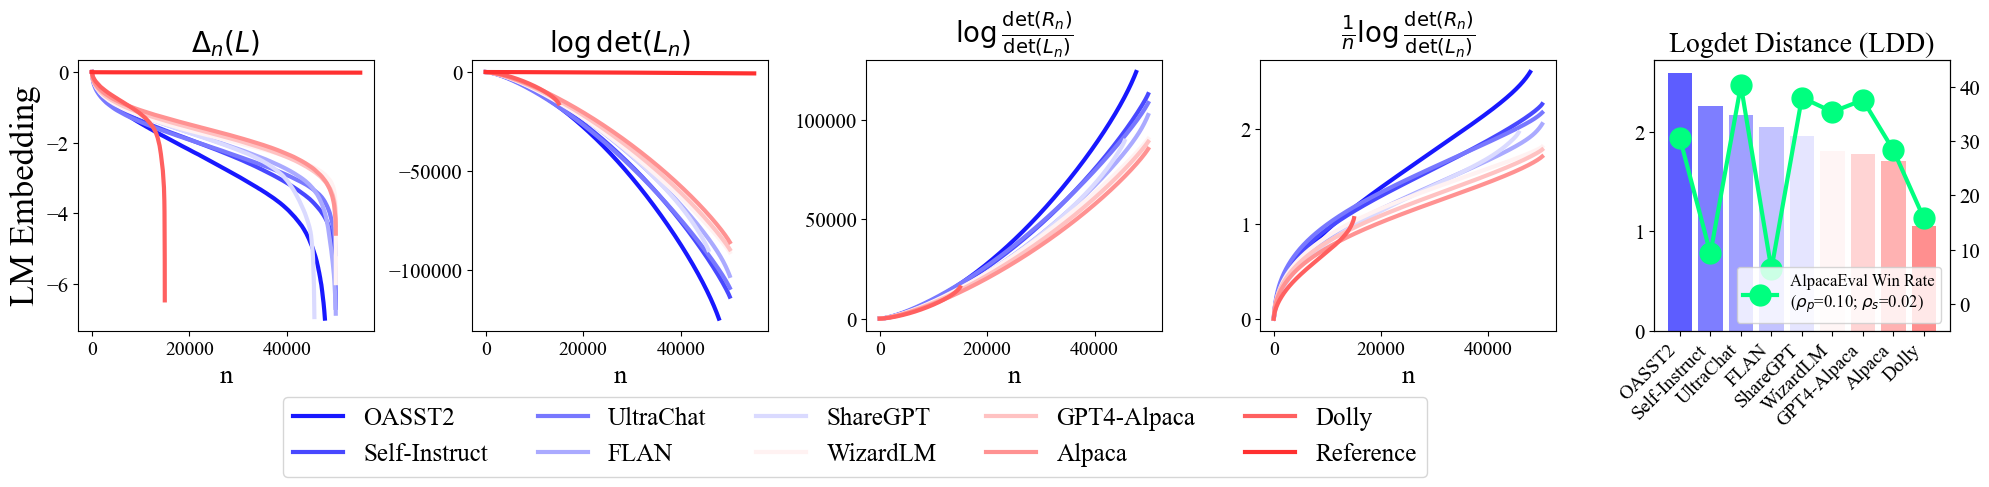

In [194]:


rcparams = {
    'lines.markersize': 15, # dot in curve size.
    'axes.titlesize': 20,   # ax title
    'axes.labelsize': 19,   # labels (x-axis and y-axis)
    'xtick.labelsize': 14,  # xtick size
    'ytick.labelsize': 15,  # ytick size
    'figure.labelsize': 25, # 
    'legend.fontsize': 18,  #| legend font size
    'lines.linewidth': 3,
    'xtick.top': False,
    'xtick.bottom': True,
}
# cmap = "coolwarm"
cmap = plt.get_cmap('coolwarm')
cmap = plt.get_cmap('bwr')


def color_fn(dataset):
    i = list(delta.keys()).index(dataset)
    x = (.5+i)/(len(delta)+.5)
    return cmap(x)


with mpl.rc_context(rcparams):
        
    sort_by = 'div'
    ncols=5
    w = 4; h = 4.5
    fig, axs = plt.subplots(1,ncols,figsize=(w*ncols,h))

    spacings = 10

    ax = axs[0]
    for i, (k, v) in enumerate(delta.items()):
        xs = np.arange(len(v))[::spacings]
        ax.plot(xs, v[xs], label=k, color=color_fn(k))
    ax.set_title(r'$\Delta_n(L)$') # := logdet(L_M)-logdet(L_{M-1}) 

    ax = axs[1]
    for k, v in logdetL.items():
        xs = np.arange(len(v))[::spacings]
        ax.plot(xs, v[xs], color=color_fn(k))
    ax.set_title(r'$\log\det(L_n)$')


    ax = axs[2]
    for k, v in logdetL_diff.items():
        v = -v
        xs = np.arange(len(v))[::spacings]
        ax.plot(xs, v[xs], color=color_fn(k))
    ax.set_title(r'$\log\frac{\det(R_n)}{\det(L_n)}$')

    ax = axs[3]
    for k, v in logdetL_diff.items():
        v = -v / (np.arange(len(v))+1)
        xs = np.arange(len(v))[::spacings]
        ax.plot(xs, v[xs], color=color_fn(k))
    ax.set_title(r'$\frac{1}{n}\log\frac{\det(R_n)}{\det(L_n)}$')


    ax = axs[4]
    xs = list(divs.keys())
    ys_div = list(divs.values())
    ys_perf = [perfs[x] if x in perfs else 0 for x in xs]
    if sort_by == 'div': sort_by_ind = 1
    elif sort_by == 'perf': sort_by_ind = 2
    else: raise ValueError()
    xs, ys_div, ys_perf = list(zip(*sorted(list(zip(xs, ys_div, ys_perf)), key=lambda x: x[sort_by_ind], reverse=True)))
    ax.bar(xs, ys_div, alpha=.7, align='center', color=[color_fn(x) for x in xs])
    ax.set_xticks(xs, xs, ha='right', rotation=45)
    title = 'Logdet Distance (LDD)'
    ax.set_title(title)
        
    axr = ax.twinx()
    ρ = scipy.stats.pearsonr(ys_div, ys_perf).statistic
    ρs = scipy.stats.spearmanr(ys_div, ys_perf).statistic
    axr.plot(xs, ys_perf, marker='o', color='#00FF7F', label='AlpacaEval Win Rate\n'+r'($\rho_{p}$'+f'={ρ:.2f}; '+r'$\rho_{s}$'+f'={ρs:.2f})')
    axr.legend(fontsize=12, loc='lower right')
    # axr.set_ylim((-19, 79))
    axr.set_ylim((-5, 45))

    for i, ax in enumerate(axs):
        if i == ncols-1:
            ax.locator_params(nbins=4, axis='y')
        else:
            ax.locator_params(nbins=4)
            ax.set_xlabel('n')

    handles, labels = axs[0].get_legend_handles_labels() 
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.43, -.1), ncol=5, frameon=True)

    axs[0].set_ylabel(r"$mpnet$ Embedding" if 'mpnet' in embedding_type else embedding_type, fontsize=25)

    fig.tight_layout()

save_plt = True
if save_plt:
    from note_pruning_analysis import assets_dir
#     save_path = os.path.join(assets_dir, (f'fig_demo_how_to_compute_diversity_and_show_corr_with_performance_{"_".join(embedding_type.split(" "))}'
#                                           f'{"" if dataset_list_name=="chat" else "_"+dataset_list_name}.pdf'))
    save_path = os.path.join(assets_dir, (f'fig_demo_how_to_compute_diversity_and_show_corr_with_performanceLCWR_{"_".join(embedding_type.split(" "))}'
                                          f'{"" if dataset_list_name=="chat" else "_"+dataset_list_name}.pdf'))
    print('save to: ', save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=100)

plt.show()

## show how diversity is computed, and show diversity vs. performance in second row

save to:  /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/assets/fig_demo_how_to_compute_diversity_LM_Weight_Gradient.pdf


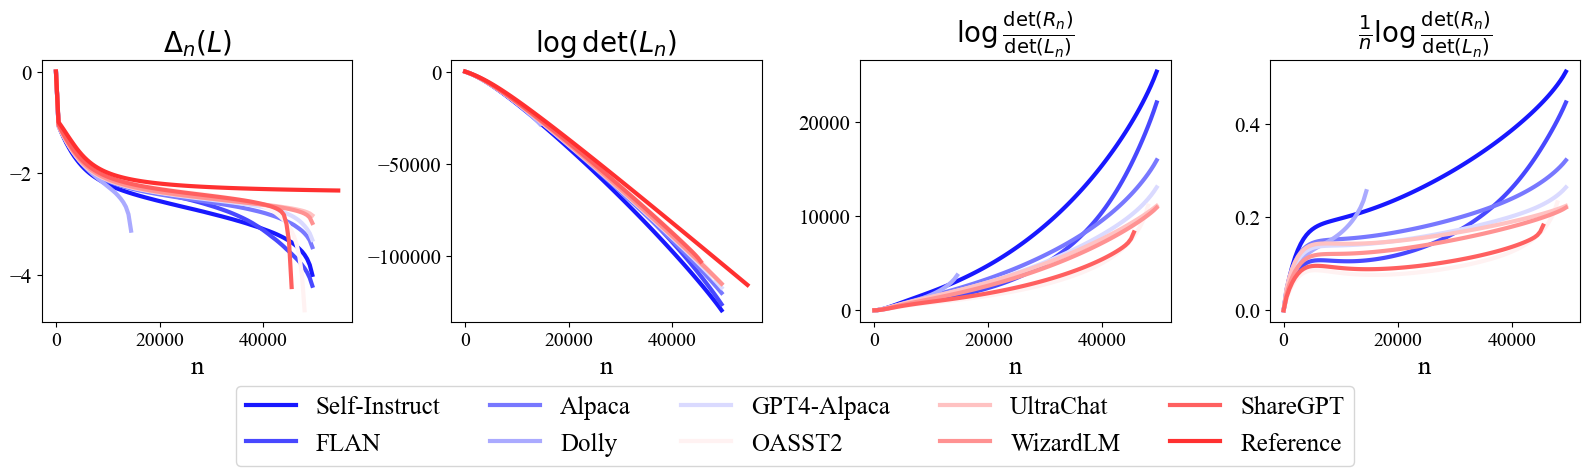

In [71]:
import matplotlib.pyplot as plt
import scipy
# from matplotlib.ticker import MultipleLocator

from matplotlib import font_manager
# font_path = '/dccstor/data-pruning/miniconda3/pkgs/mscorefonts-0.0.1-3/fonts/times.ttf'  # Your font path goes here
font_path = '/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/pkgs/mscorefonts-0.0.1-3/fonts/times.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

rcparams = {
    'axes.titlesize': 20,   # ax title
    'axes.labelsize': 19,   # labels (x-axis and y-axis)
    'xtick.labelsize': 14,  # xtick size
    'ytick.labelsize': 15,  # ytick size
    'figure.labelsize': 25, # 
    'legend.fontsize': 18,  #| legend font size
    'lines.linewidth': 3,
    'xtick.top': False,
    'xtick.bottom': True,
}


# cmap = "coolwarm"
cmap = plt.get_cmap('coolwarm')
cmap = plt.get_cmap('bwr')


def color_fn(dataset):
    i = list(delta.keys()).index(dataset)
    x = (.5+i)/(len(delta)+.5)
    return cmap(x)

with mpl.rc_context(rcparams):

    sort_by = 'div'
    ncols=4
    w = 4; h = 4
    fig, axs = plt.subplots(1,ncols,figsize=(w*ncols,h))

    spacings = 500

    ax = axs[0]
    for i, (k, v) in enumerate(delta.items()):
        xs = np.arange(len(v))[::spacings]
        ax.plot(xs, v[xs], label=k, color=color_fn(k))
    ax.set_title(r'$\Delta_n(L)$') # := logdet(L_M)-logdet(L_{M-1}) 

    ax = axs[1]
    for k, v in logdetL.items():
        xs = np.arange(len(v))[::spacings]
        ax.plot(xs, v[xs], color=color_fn(k))
    ax.set_title(r'$\log\det(L_n)$')


    ax = axs[2]
    for k, v in logdetL_diff.items():
        v = -v
        xs = np.arange(len(v))[::spacings]
        ax.plot(xs, v[xs], color=color_fn(k))
    ax.set_title(r'$\log\frac{\det(R_n)}{\det(L_n)}$')

    ax = axs[3]
    for k, v in logdetL_diff.items():
        v = -v / (np.arange(len(v))+1)
        xs = np.arange(len(v))[::spacings]
        ax.plot(xs, v[xs], color=color_fn(k))
    ax.set_title(r'$\frac{1}{n}\log\frac{\det(R_n)}{\det(L_n)}$')

    for i, ax in enumerate(axs):
        ax.set_xlabel('n')
        ax.locator_params(nbins=4)

    handles, labels = fig.axes[0].get_legend_handles_labels() 
#     fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -.1), ncol=9, frameon=True)
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -.21), ncol=5, frameon=True)
    fig.tight_layout()
    fig.show()
    

save_plt = True
if save_plt:
    from note_pruning_analysis import assets_dir
    save_path = os.path.join(assets_dir, f'fig_demo_how_to_compute_diversity_{"_".join(embedding_type.split(" "))}.pdf')
    print('save to: ', save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=100)

plt.show()

save to:  /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/assets/fig_demo_diversity_vs_performanceLCWR_across_dataset_LM_Weight_Gradient_equal.pdf


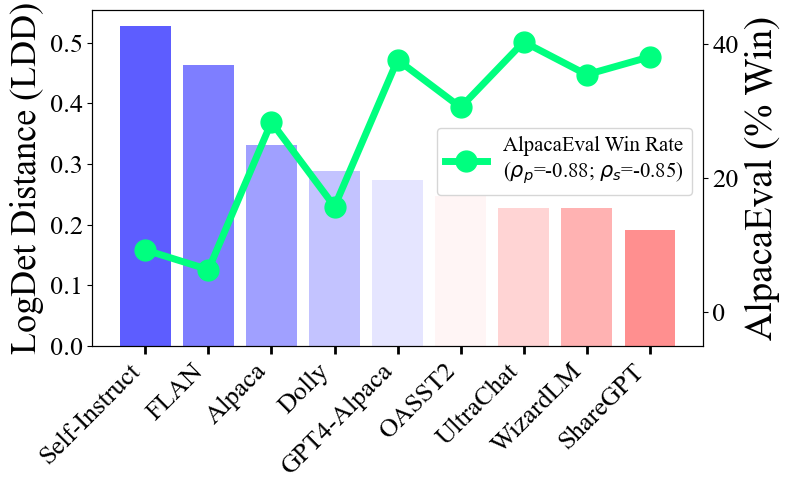

In [188]:
import matplotlib.pyplot as plt

        
rcparams = {
    'lines.markersize': 15, # dot in curve size.
    'axes.labelsize': 28,   # labels (x-axis and y-axis)
    'xtick.labelsize': 19,  # xtick labels
    'ytick.labelsize': 19,
    'legend.fontsize': 18,  # legend font size
    'lines.linewidth': 5,
    'xtick.major.size': 6,
    'xtick.major.width': 2,
    # 'xtick.top': True, 'xtick.bottom': False,
    'xtick.top': False, 'xtick.bottom': True,
}

cmap = plt.get_cmap('bwr')


def color_fn(dataset):
    i = list(delta.keys()).index(dataset)
    x = (.5+i)/(len(delta)+.5)
    return cmap(x)
sort_by = 'div'
aspect = 'equal'

with mpl.rc_context(rcparams):
    
    
    if aspect == 'equal':
        rotation = 45
        w = 8; h = 5
    else:
        rotation = 0
        w = 4; h = 4
    fig, ax = plt.subplots(1,1,figsize=((1 if aspect == 'equal' else 4)*w, h))

    xs = list(divs.keys())
    ys_div = list(divs.values())
    ys_perf = [perfs[x] for x in xs]
    if sort_by == 'div': sort_by_ind = 1
    elif sort_by == 'perf': sort_by_ind = 2
    else: raise ValueError()
    xs, ys_div, ys_perf = list(zip(*sorted(list(zip(xs, ys_div, ys_perf)), key=lambda x: x[sort_by_ind], reverse=True)))
    ax.bar(xs, ys_div, alpha=.7, align='center', color=[color_fn(x) for x in xs])
#     ax.tick_params(axis='x',which='both',labelbottom=False) 
#     ax.xaxis.set_tick_params(labeltop='on')
    ax.set_xticks(xs, xs, ha='right', rotation=rotation)
    #ax.set_ylabel(r'Diversity$\triangleq\frac{1}{n}\log\frac{\det(L)}{\det(R)}$')
    ax.set_ylabel('LogDet Distance (LDD)', fontsize=26)

    axr = ax.twinx()
    ρ = scipy.stats.pearsonr(ys_div, ys_perf).statistic
    ρs = scipy.stats.spearmanr(ys_div, ys_perf).statistic
    axr.plot(xs, ys_perf, marker='o', color='#00FF7F', label='AlpacaEval Win Rate\n'+r'($\rho_{p}$'+f'={ρ:.2f}; '+r'$\rho_{s}$'+f'={ρs:.2f})')
    if aspect == 'equal':
        axr.legend(loc='center right', bbox_to_anchor=(1, .55), fontsize=15)
    else:
        axr.legend(loc='center right', bbox_to_anchor=(1, .65))
    axr.set_ylim((-5, 45))
    axr.set_ylabel('AlpacaEval (% Win)')
#     axr.set_xticks(xs, xs, ha='center', rotation=rotation)
    
    axr.locator_params(nbins=4, axis='y')
    
#     if aspect == 'equal':
#         ax.set_aspect('equal')
#         axr.set_aspect('equal')
    
    fig.tight_layout()

save_plt = True
if save_plt:
    from note_pruning_analysis import assets_dir
    # save_path = os.path.join(assets_dir, f'fig_demo_diversity_vs_performance_across_dataset_{"_".join(embedding_type.split(" "))}_{aspect}.pdf')
    save_path = os.path.join(assets_dir, f'fig_demo_diversity_vs_performanceLCWR_across_dataset_{"_".join(embedding_type.split(" "))}_{aspect}.pdf')
    print('save to: ', save_path)
    fig.savefig(save_path, bbox_inches='tight', dpi=100)

plt.show()

## explore various different metrics 

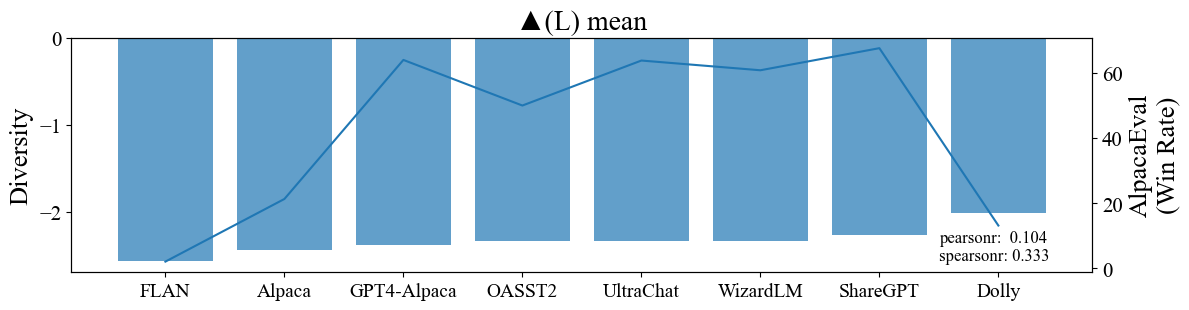

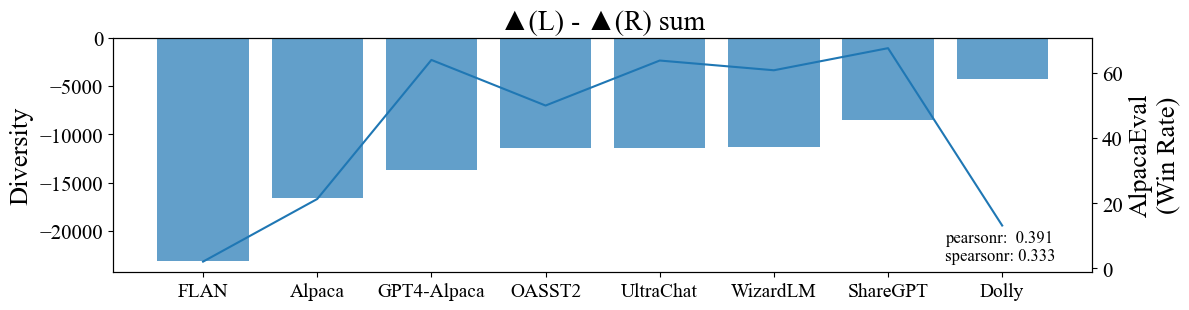

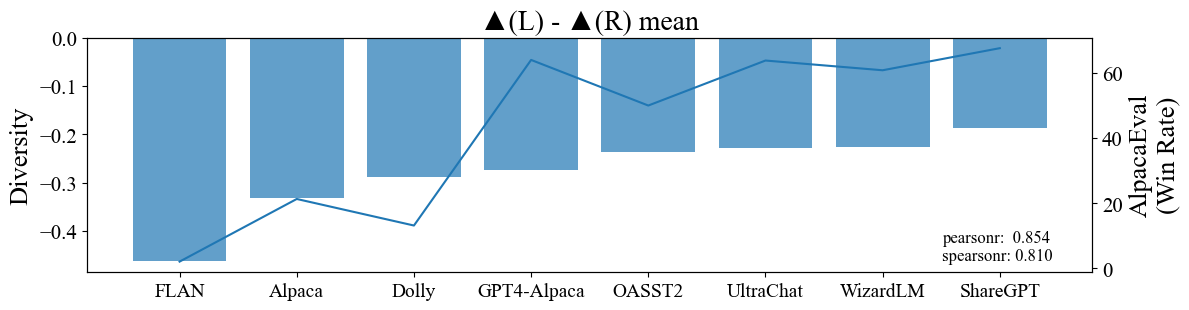

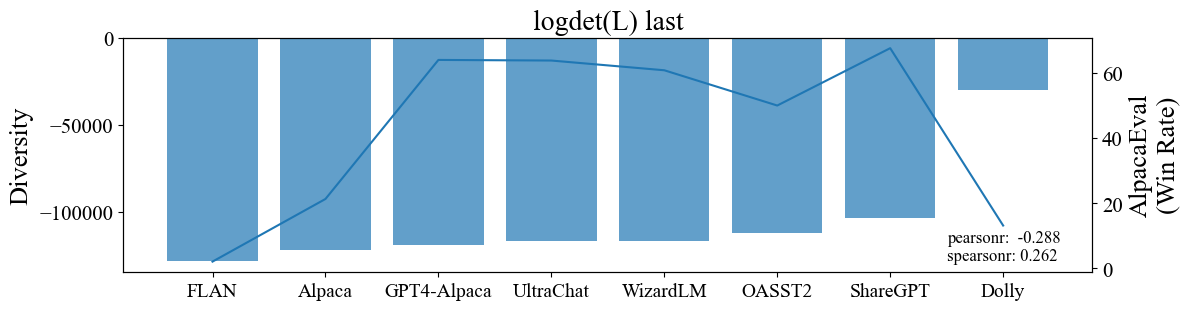

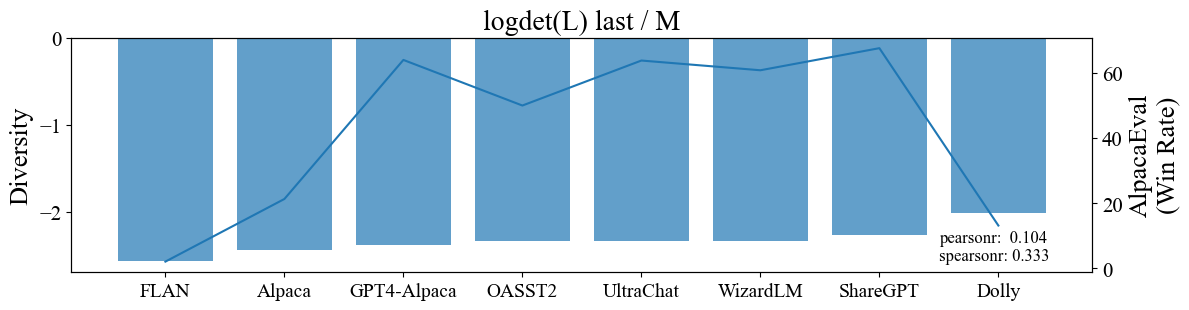

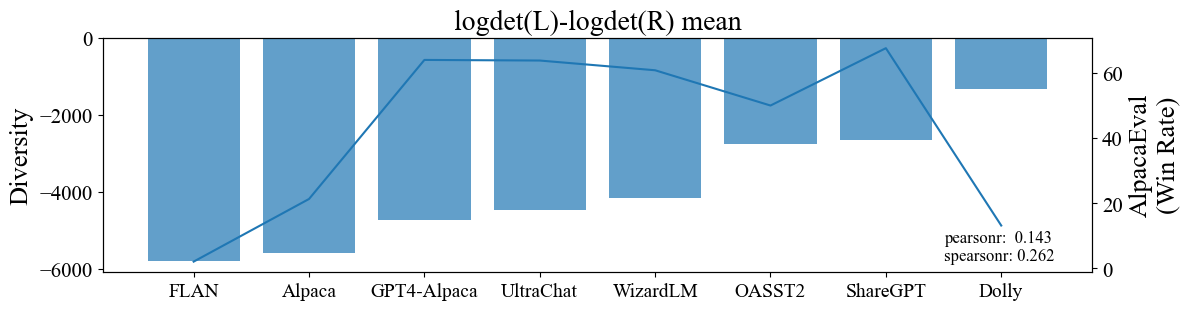

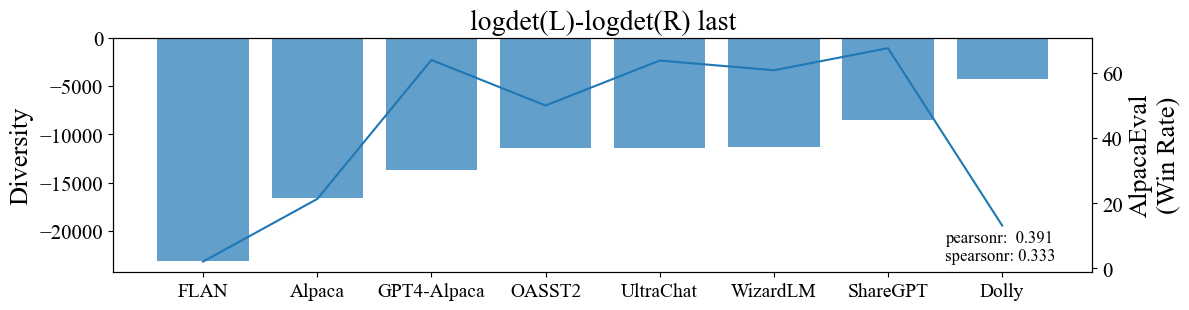

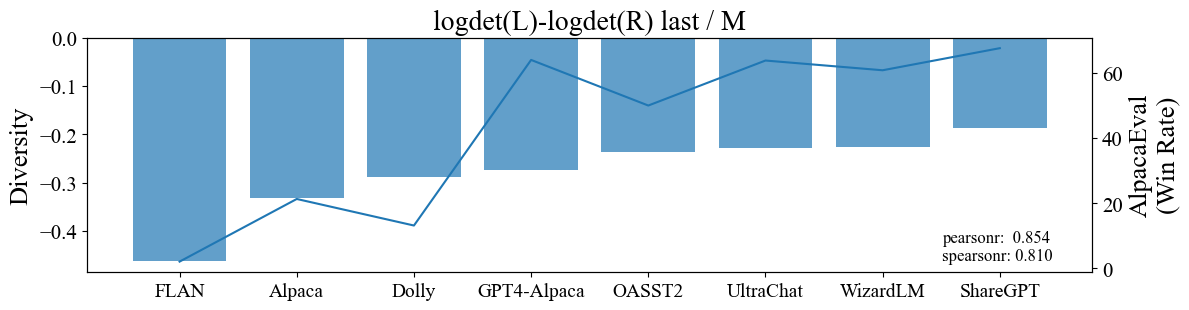

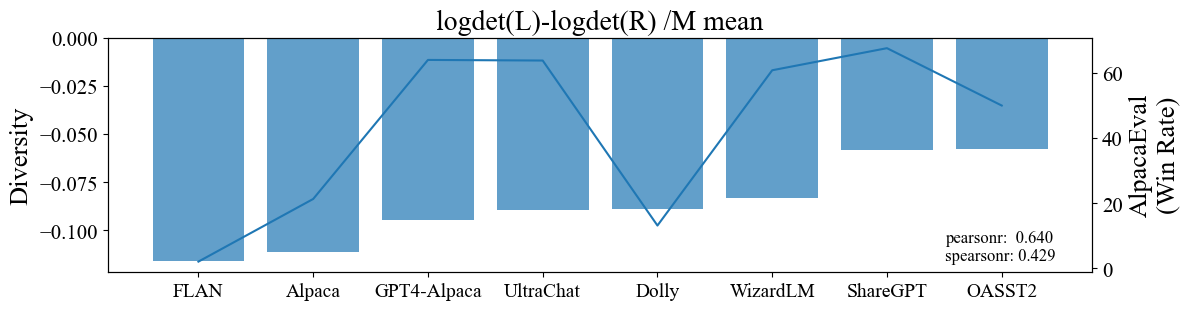

In [219]:
div_metrics = {
    '▲(L) mean': {k: v.mean() for k, v in delta.items()},
    '▲(L) - ▲(R) sum': {k: v.sum() for k, v in delta_diff.items()},
    '▲(L) - ▲(R) mean': {k: v.mean() for k, v in delta_diff.items()},
#     'logdet(L) mean': {k: v.mean() for k, v in logdetL.items()}, # does not really makes sense, just take last one to get total volume
    'logdet(L) last': {k: v[-1] for k, v in logdetL.items()},
    'logdet(L) last / M': {k: v[-1]/len(v) for k, v in logdetL.items()},
    'logdet(L)-logdet(R) mean': {k: v.mean() for k, v in logdetL_diff.items()},
    'logdet(L)-logdet(R) last': {k: v[-1] for k, v in logdetL_diff.items()},
    'logdet(L)-logdet(R) last / M': {k: v[-1]/len(v) for k, v in logdetL_diff.items()},
    'logdet(L)-logdet(R) /M mean': {k: np.mean(v/len(v)) for k, v in logdetL_diff.items()},
}

# div_metrics = {
#     'logdet(L)-logdet(R) last / M': {k: v[-1]/len(v) for k, v in logdetL_diff.items()},
# }

for div_name, div in div_metrics.items():
    div = {k: v for k, v in div.items() if k not in ['Reference']}
    fig, ax = plt_diversity_and_performance(div, sort_by='div')
    ax.set_title(div_name)

In [152]:
import scipy
perfs = {'flan_v250k': 2.111801242236025, 'dolly': 13.167701863354036, 'stanford_alpaca50k': 21.304347826086957, 'oasst2': 49.93788819875776, 'wizardlm50k': 60.745341614906835, 'ultrachat50k': 63.72670807453416, 'gpt4_alpaca50k': 63.913043478260875, 'sharegpt50k': 67.51552795031056}
pref_academicbench = {'oasst2': 22.217772301009884, 'ultrachat50k': 22.90774015084645, 'stanford_alpaca50k': 22.989997233965415, 'gpt4_alpaca50k': 23.189254803071105, 'dolly': 24.081346866510223, 'wizardlm50k': 24.222268910222496, 'sharegpt50k': 24.45554782583774, 'flan_v250k': 26.426821396438108}

perfs = {get_dataset_display(k): v for k, v in perfs.items()}

def plt_diversity_and_performance(divs, sort_by='div'):
    xs = list(divs.keys())

    ys_div = [divs[x] for x in xs]
    ys_perf = [perfs[x] for x in xs]
    
    if sort_by == 'div': sort_by_ind = 1
    elif sort_by == 'perf': sort_by_ind = 2
    else: raise ValueError()
    xs, ys_div, ys_perf = list(zip(*sorted(list(zip(xs, ys_div, ys_perf)), key=lambda x: x[sort_by_ind])))


    fig, ax = plt.subplots(1,1,figsize=(12,3))
    
    ax.bar(xs, ys_div, alpha=.7, align='center', label='diversity')
#     ax.plot(xs, ys_div, alpha=.7, label='diversity')
#     ax.set_ylim(top=0)
    ax.set_ylabel('Diversity')
    
    axr = ax.twinx()
    axr.plot(xs, ys_perf, label='performance')
    axr.set_ylabel('AlpacaEval\n(Win Rate)')
    
    s = (f"pearsonr:  {scipy.stats.pearsonr(ys_div, ys_perf).statistic:.3f}\n"
         f"spearsonr: {scipy.stats.spearmanr(ys_div, ys_perf).statistic:.3f}")
    ax.text(0.85, 0.05, s, transform=ax.transAxes, fontsize=12, horizontalalignment='left')

    
    fig.tight_layout()
    return fig, ax

perfs

{'FLAN': 2.111801242236025,
 'Dolly': 13.167701863354036,
 'Alpaca': 21.304347826086957,
 'OASST2': 49.93788819875776,
 'WizardLM': 60.745341614906835,
 'UltraChat': 63.72670807453416,
 'GPT4-Alpaca': 63.913043478260875,
 'ShareGPT': 67.51552795031056}

In [40]:
from note_pruning_analysis import get_dataset
from note_pruning_analysis import lm_output_dir
import numpy as np
import pickle


dataset = 'lima'
D = 4096

def generate_randsphere_model_output(dataset, D):
    

    ds = get_dataset(dataset)
    N = len(ds)

    np.random.seed(0)
    X = random_uniform_hypersphere_surface(N, D)
    X = X.astype(np.float32)


    save_dir = os.path.join(lm_output_dir, 'sft', 'randsphere')
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'{dataset}.pkl')
    with open(save_path, 'wb') as f:
        output = {
            'grad_rp_loraB': X,
        }
        pickle.dump(output, f, protocol=pickle.HIGHEST_PROTOCOL)



Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/lima/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


In [41]:

from note_pruning_analysis import generate_randsphere_model_output
dataset_list = [
    'stanford_alpaca', 
    'sharegptv2',
    'wizardlmv2',
    'oasst1',
    'flan_v2',
    'dolly',
    'ultrachat200kv2',
    'lima',
]
for dataset in dataset_list:
    generate_randsphere_model_output(dataset, D=4096, model_name='randspherep4096')

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/stanford_alpaca/json/default-b6766d38a0ddb739/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/sharegpt/json/default-e06115df4f1016b7/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-ee4a9c17618cfeb6/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-7a3a4cd7ac543b88/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023

In [42]:
from note_pruning_analysis import get_lm_output

d = get_lm_output('lima', 'randspherep4096')
d

{'grad_rp_loraB': array([[ 0.02802381,  0.00635691,  0.01554827, ...,  0.0073691 ,
          0.00981219,  0.03965819],
        [ 0.02568289, -0.00156109, -0.00318369, ...,  0.01049783,
          0.0083857 , -0.01656225],
        [-0.00824596, -0.03085298, -0.00146003, ...,  0.0079379 ,
         -0.00246746,  0.01078339],
        ...,
        [ 0.02143434,  0.02957007,  0.01409724, ..., -0.00313032,
         -0.01287347, -0.00183235],
        [ 0.01679143, -0.04404007, -0.00762888, ...,  0.01354863,
          0.01411676,  0.03258975],
        [ 0.02116297,  0.00442414,  0.00313984, ..., -0.00217247,
          0.00325706,  0.03190288]], dtype=float32)}

/tmp/ipykernel_3141730/2507557644.py:42: RuntimeWarning: divide by zero encountered in divide
  ax.plot(mg_cumsum/mg_rand_cumsum)
/tmp/ipykernel_3141730/2507557644.py:51: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[i, 1].get_shared_y_axes().join(axs[i, 1], axs[0, 1])


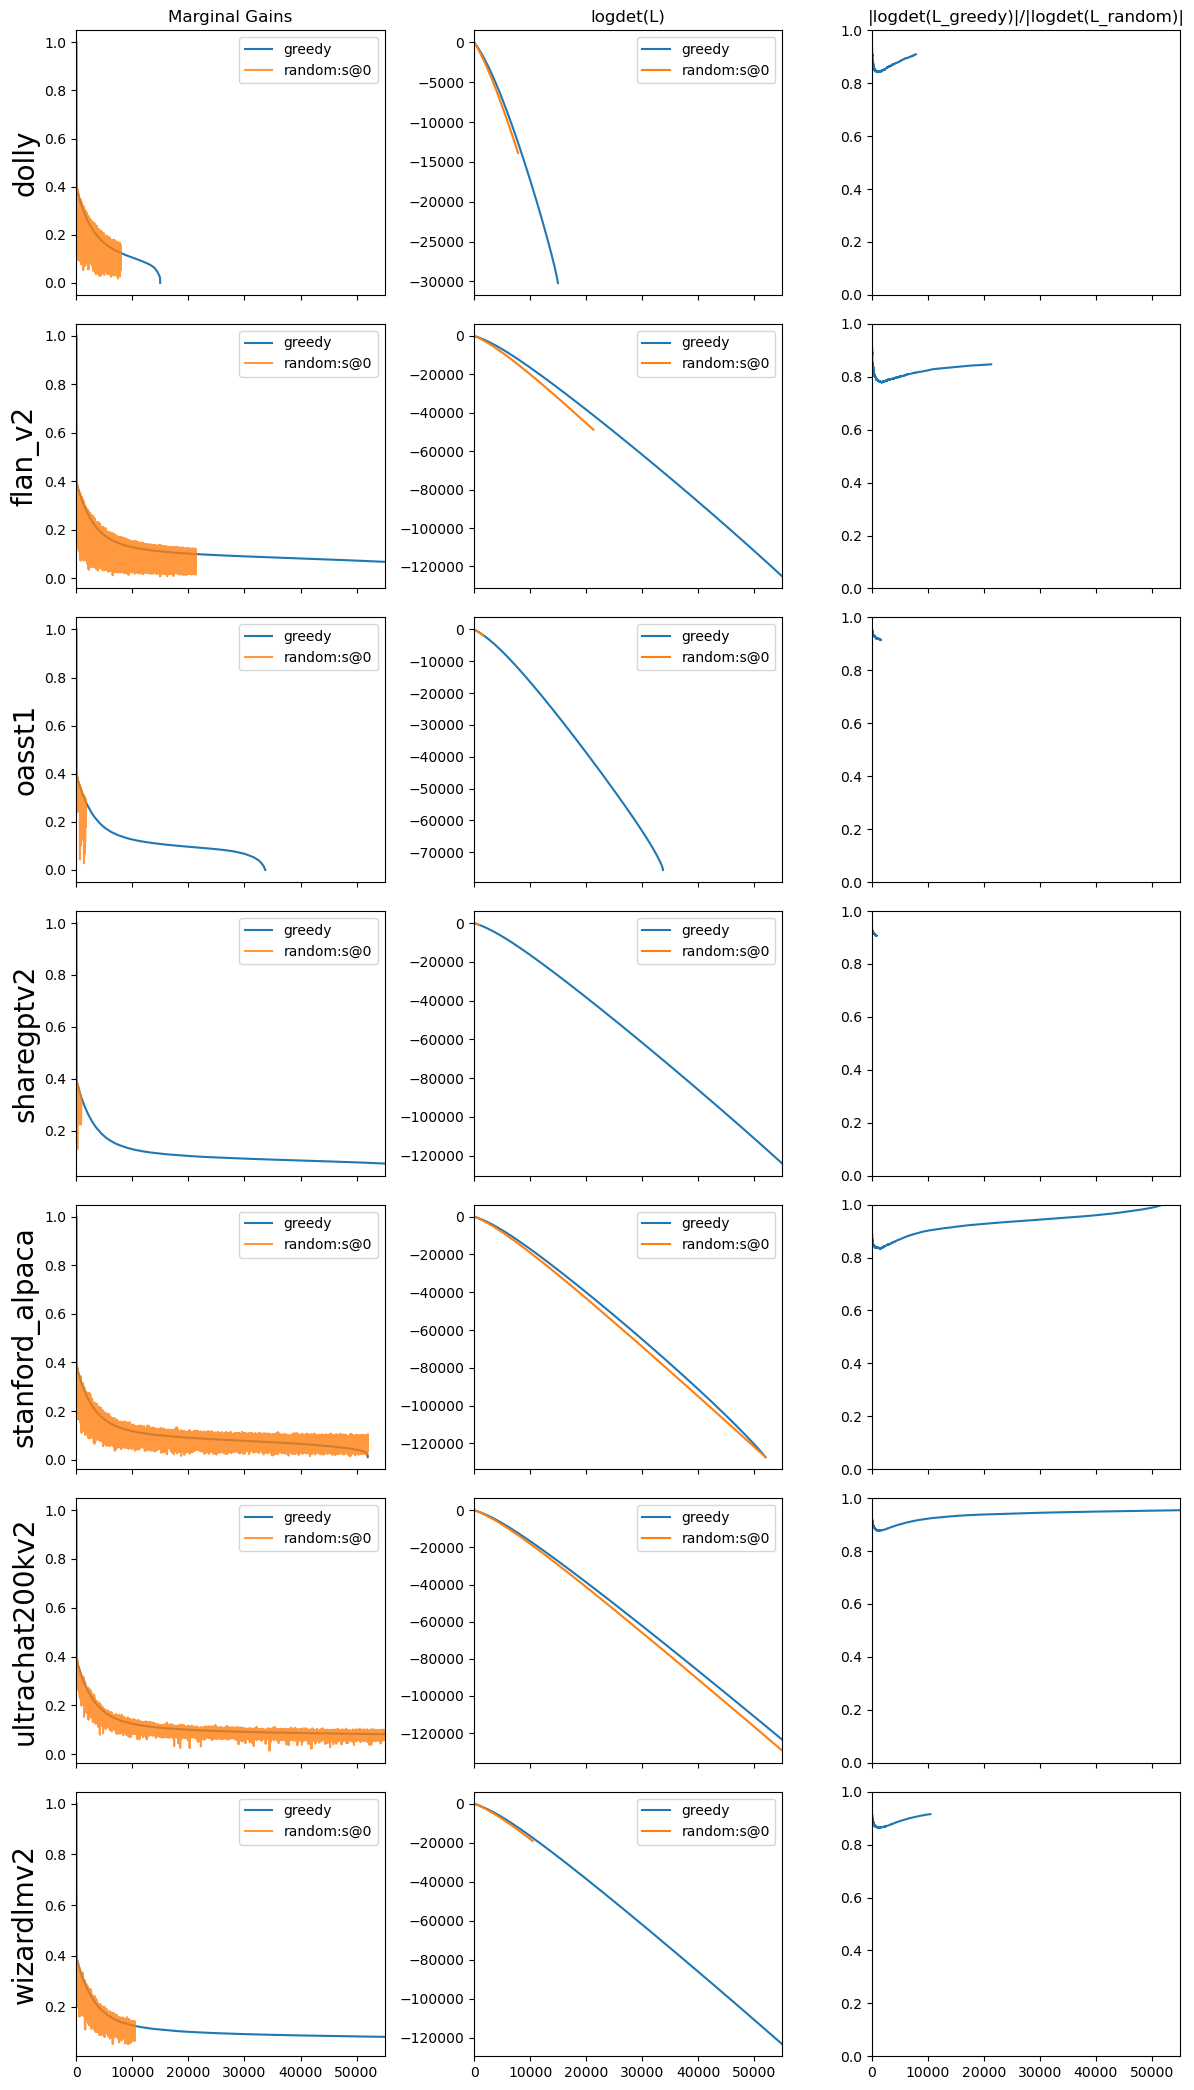

In [11]:
import matplotlib.pyplot as plt
import pickle


nrows = len(dataset_list)

fig, axs = plt.subplots(nrows, 3, figsize=(3*4,3*nrows), sharex=True)
axs = axs.reshape(-1, 3)

xlim = (0, 55_000)
# xlim = (None, None)
# xlim = (0, 10_000)
for i, dataset in enumerate(dataset_list):
    mgs_ds = {k[1]: mgs[k] for k in list(mgs.keys()) if k[0]==dataset}

    ax = axs[i,0]

    for k, mg in mgs_ds.items():
        ax.plot(np.exp(mg), label=k, alpha=1 if k=='greedy' else .8)
    ax.set_ylabel(dataset, fontsize=20)
    ax.legend()
    ax.set_xlim(xlim)
#     ax.set_ylim((18, 23))

    ax = axs[i, 1]
    for k, mg in mgs_ds.items():
        ax.plot(np.cumsum(mg), label=k)
    ax.legend()
    ax.set_xlim(xlim)
#     ax.set_ylim((0, 1e6))
    
    ax = axs[i, 2]
#     mg_rand_cumsum = np.abs(np.cumsum(mgs_ds['random:s@0']))
#     mg_cumsum = np.abs(np.cumsum(mgs_ds['greedy']))
#     mg_rand_cumsum = np.cumsum(np.log(np.abs(np.exp(mgs_ds['random:s@0']))))
#     mg_cumsum = np.cumsum(np.log(np.abs(np.exp(mgs_ds['greedy']))))
    mg_rand_cumsum = np.cumsum(mgs_ds['random:s@0'])
    mg_cumsum = np.cumsum(mgs_ds['greedy'])
    max_len = min(len(mg_rand_cumsum), len(mg_cumsum))
    mg_rand_cumsum = mg_rand_cumsum[:max_len]
    mg_cumsum = mg_cumsum[:max_len]
    ax.plot(mg_cumsum/mg_rand_cumsum)
    ax.set_xlim(xlim)
    ax.set_ylim((0, 1))
#     ax.set_ylim((1, 1.02))
    # ax.plot(mg_cumsum-mg_rand_cumsum)
    

# Share y-axis for the second column
for i in range(1, nrows):
    axs[i, 1].get_shared_y_axes().join(axs[i, 1], axs[0, 1])

    
axs[0, 0].set_title('Marginal Gains')
axs[0, 1].set_title('logdet(L)')
axs[0, 2].set_title('|logdet(L_greedy)|/|logdet(L_random)|')
    

# fig.suptitle(sort_by)
fig.tight_layout()

In [1]:
import pickle
dataset = 'stanford_alpaca'
sort_by = 'dppmap_k=vmf_gamma=3.43e-05_kmd=llama7br256p4096_kemb=grad+rp+loraB'

# dataset = 'sharegptv2'
# sort_by = 'dppmap_k=vmf_gamma=5.7e-05_kmd=llama7b_kemb=grad+rp+loraB'

p = (f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/dpp/{dataset}/'
     f'{sort_by}_ord=random:s@1/data.pkl')
with open(p, 'rb') as f:
    o = pickle.load(f)
mg_rand = o['marginal_gains'][1:]

p = (f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/dpp/{dataset}/'
     f'{sort_by}/data.pkl')
with open(p, 'rb') as f:
    o = pickle.load(f)
mg = o['marginal_gains'][1:]

fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
ax.plot(mg_rand, label='random')
ax.plot(mg, label='greedy')
ax.set_ylabel('di2')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')

ax = axs[1]
ax.plot(np.cumsum(mg_rand), label='random')
ax.plot(np.cumsum(mg), label='greedy')
ax.set_ylabel('cumulative di2')
# ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')

NameError: name 'plt' is not defined